In [120]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import t
from scipy.stats import t as t_dist

from matplotlib.ticker import MultipleLocator

# function

In [121]:
def gaussian_offset(x, A, mu, sigma,a, b, c, d):
    return A*np.exp(-(x-mu)**2/(2*sigma**2)) + b * np.exp(-a * x) + c*x + d

In [122]:
def fit_func_1(spectrum, center, dx=15, kev=False, energies=None, ax=None):
    if kev:
        mask = (energies > center - dx) & (energies < center + dx)
        x_data = energies[mask]
        y_data = spectrum[mask]
    else:
        window = dx       
        x_data = np.arange(center - window, center + window + 1)
        y_data = spectrum[center - window:center + window + 1]

    valid_mask = y_data > 0
    x_data = x_data[valid_mask]
    y_data = y_data[valid_mask]

    err_counts = [np.sqrt(c) if c > 0 else 1 for c in y_data]
    '''
    initial_guess = [max(y_data), center, 5, 0, 1]
    bounds = (
        [0, center - 5, 0.01, -10000, 0],
        [1000* max(y_data), center + 5, 50, 10000, max(y_data)]
    )
    '''
    #A*np.exp(-(x-mu)**2/(2*sigma**2)) + b * np.exp(-a * x) + c*x + d
    '''
    initial_guess = [max(y_data), center, 5, 0, 1, 0.00010]
    bounds = (
        [0, center - 5, 0.01, 0, 0, 0],
        [10000000000, center + 5, 50, 100, 10000000000, 500000]
    )
    '''
    initial_guess = [10000, center, 100, 100, 100, -10, 10000]
    bounds = ([0, center - 25, 0,0,0, -100000000000, 0],
             [10000000000000, center + 25, 200, 100000000000, 100000000000, 0, 100000000000])
    popt, pcov = curve_fit(gaussian_offset, x_data, y_data, sigma=err_counts, p0=initial_guess, bounds=bounds)
    err = np.sqrt(np.diag(pcov))

    if ax is None:
        ax = plt.gca()

    bins = np.linspace(min(x_data), max(x_data), int(len(x_data))+1)
    counts, bin_edges, _ = ax.hist(x_data, bins=bins, weights=y_data,
                                  histtype='step', color = 'black', label='Hist data')
  
    db = 0.5*(bin_edges[1]-bin_edges[0])
    xfit = np.linspace(x_data[0], x_data[-1], 500)
    yfit = gaussian_offset(xfit, *popt)
    ax.plot(xfit, yfit, color='deepskyblue', lw=2, label='Gaussian fit')
    ax.set_xlim(min(x_data), max(x_data))
    if kev:
        ax.vlines(popt[1], 0, max(gaussian_offset(x_data, *popt)), color='deepskyblue', lw=2, linestyle='--', label=f'Peak: {popt[1]:.2f} keV')
        ax.set_xlabel('E [keV]', size = 12)
        ax.set_title(f'Gaussian fit @ {center} keV', size = 15)
        ax.set_ylabel(f'Counts / {db:.1f} keV', size = 12)
    else:
        ax.vlines(popt[1], 0, max(gaussian_offset(x_data, *popt)), color='deepskyblue', lw=2, linestyle='--', label=f'Peak: {popt[1]:.2f}')
        ax.set_xlabel('Channel', size = 12)
        ax.set_title(f'Gaussian fit @ {center} chn', size = 15)
        ax.set_ylabel(f'Counts / {db:.1f} chn', size = 12)
    ax.grid(alpha=0.25)
    ax.legend()

    return popt, err




# Funzione di fit in channel e kev
def fit_func_1(spectrum, center, dx=15, kev = False, energies = None):
    if kev:
        mask = (energies > center - dx) & (energies < center + dx)
        x_data = energies[mask]
        y_data = spectrum[mask]
    else:
        window = dx       
        x_data = np.arange(center - window, center + window + 1)
        y_data = spectrum[center - window:center + window + 1]

    valid_mask = y_data > 0
    x_data = x_data[valid_mask]
    y_data = y_data[valid_mask]

    err_counts = []
    for c in y_data:
        if c == 0:
            err_counts.append(1)

        else:
            err_counts.append(np.sqrt(c))

    # Parametri iniziali: A, mu, sigma, offset
    initial_guess = [max(y_data), center,5,  0, 10]
    bounds = (
        [0, center - 5, 0.01,  -10000, 0],
        [1000* max(y_data), center + 5, 500,  10000, np.inf]
    )

    # Fit gaussiano
    # uso come incertezze le radice del numero di conteggi in quanto ho uno spettro poissoniano
    popt, pcov = curve_fit(gaussian_offset, x_data, y_data, sigma =err_counts, p0=initial_guess, bounds = bounds)
    err = np.sqrt(np.diag(pcov))
    
    # Plot fit
    # Creazione dell'istogramma (anche se i dati sono già binned)
    counts, bin_edges, _ = plt.hist(x_data, bins=len(x_data), weights=y_data,
                                    histtype='stepfilled', label='Data')
    plt.scatter(x_data, y_data, color = 'orange')
    xfit = np.linspace(x_data[0], x_data[-1], 500)
    yfit = gaussian_offset(xfit, *popt)
    plt.plot(xfit,yfit, color = 'darkorange', lw=2, label='Guassian fit ')
    if kev:
        plt.vlines(popt[1], 0, max(gaussian_offset(x_data, *popt)), color='darkorange',lw=2, linestyle='--', label=f'Peak: {popt[1]:.2f} keV')
        plt.xlabel('E [keV]')
        plt.title(f'Gaussian fit @ {center} keV')
    else:
        plt.vlines(popt[1], 0, max(gaussian_offset(x_data, *popt)), color='darkorange',lw=2, linestyle='--', label=f'Peak: {popt[1]:.2f}')
        plt.xlabel('Channel')
        plt.title(f'Gaussian fit @ {center} chn')
    plt.ylabel(f'Counts')
    plt.grid(alpha=0.25)
    plt.legend()
    plt.show()

    return popt, err

In [123]:
def k_calibration(E_chn, a, b, c):
    return E_chn**2 * a + b * E_chn + c

In [124]:
def t_test_theoretical(x_exp, sigma, x_theo, dof=1):
    t_stat = (x_exp - x_theo) / sigma
    print(f't = {t_stat:.2f}')
    
    # p-value a due code
    p_value = 2 * t_dist.sf(abs(t_stat), df=dof)

    if p_value < 0.05:
        print('❌ p < 0.05 ')
    else:
        print('✅ p > 0.05 ')
    print(f'p-value = {p_value:.4f}')
    return t_stat, p_value

In [125]:
import numpy as np

def fwhm_percentuale(sigma, delta_sigma, E, delta_E):

    sigma = np.array(sigma)
    delta_sigma = np.array(delta_sigma)
    E = np.array(E)
    delta_E = np.array(delta_E)

    # Calcolo FWHM percentuale: (2.355 * sigma) / E 
    fwhm_perc = (2.355 * sigma / E) 

    # Propagazione dell'errore relativa
    rel_err_sigma = delta_sigma / sigma
    rel_err_E = delta_E / E
    delta_fwhm_perc = fwhm_perc * np.sqrt(rel_err_sigma**2 + rel_err_E**2)

    return fwhm_perc, delta_fwhm_perc

In [126]:
def fhwm_func(E, a, b):
    return np.sqrt( (a / np.sqrt(E))**2 + b**2)


# Tempi

In [127]:
t_bk_open_live =11772
t_bk_open_real = 11782

In [128]:
t_bk_closed_live =11001
t_bk_closed_real = 11001

In [129]:
t_lense_open_live =994
t_lense_open_real = 1099

In [130]:
t_lense_closed_live =862
t_lense_closed_real = 971

# background unshilded

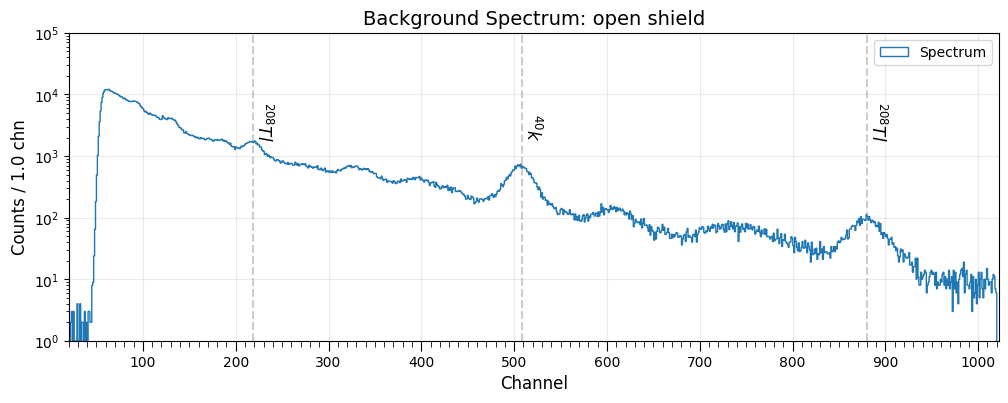

In [241]:
file_path = "bkg-unshileded.csv.csv"
data = pd.read_csv(file_path, header=None)
plt.figure(figsize=(12, 4))

dx = 100
dy = 10
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero




# Ensure data is 1D (each count per channel/bin)
spectrum = data[0].values
#spectrum = spectrum/(1-(t_bk_open_live/t_bk_open_real))
chn = np.arange(len(spectrum))  # canali da 0 a N-1
bins = np.linspace(min(chn), max(chn), int(len(chn))+1)
hist, bin_edge, _ = plt.hist(chn, bins = bins, weights= spectrum, histtype='step', ec='k',label='Spectrum')
db = (bin_edge[1]-bin_edge[0])
chn = [217, 508, 605, 745, 880]
chn = [219, 508, 880]
#chn = [ 508, 880]
name = [ r"$^{208}Tl$",  r"$^{40}k$",  r"$^{208}Tl$"]
for v,iso in zip(chn,name):
     plt.axvline(x=v, color='gray', linestyle='--', alpha=0.4)
     plt.text(v , 2000, iso, rotation=270,  size = 12)
    


plt.xlabel('Channel', size = 12)
plt.ylabel(f'Counts / {db:.1f} chn', size = 12)
plt.title('Background Spectrum: open shield', size = 14)
plt.xlim(20, len(spectrum))
#plt.xlim(650, 900)
#plt.vlines(505, 0, 1500)
plt.ylim(1,100000)
plt.yscale('log')
plt.legend()
plt.grid(alpha =0.25)
plt.savefig("new NAI/chn_background_open", dpi=300, bbox_inches='tight')

plt.show()

[ 572.25598956  218.87045963    6.83180629 2631.43395806  569.02579815
  -12.32277719 3859.75840757]
[ 5.15543979e+02  5.06719626e+02  1.25949703e+01  5.82568548e+03
  2.53853468e+02 -8.23558781e-01  5.77685369e+02]
[ 7.13519649e+01  8.81056943e+02  1.67803512e+01  1.13037689e+05
  2.56318877e+05 -1.40624442e-01  1.44221092e+02]


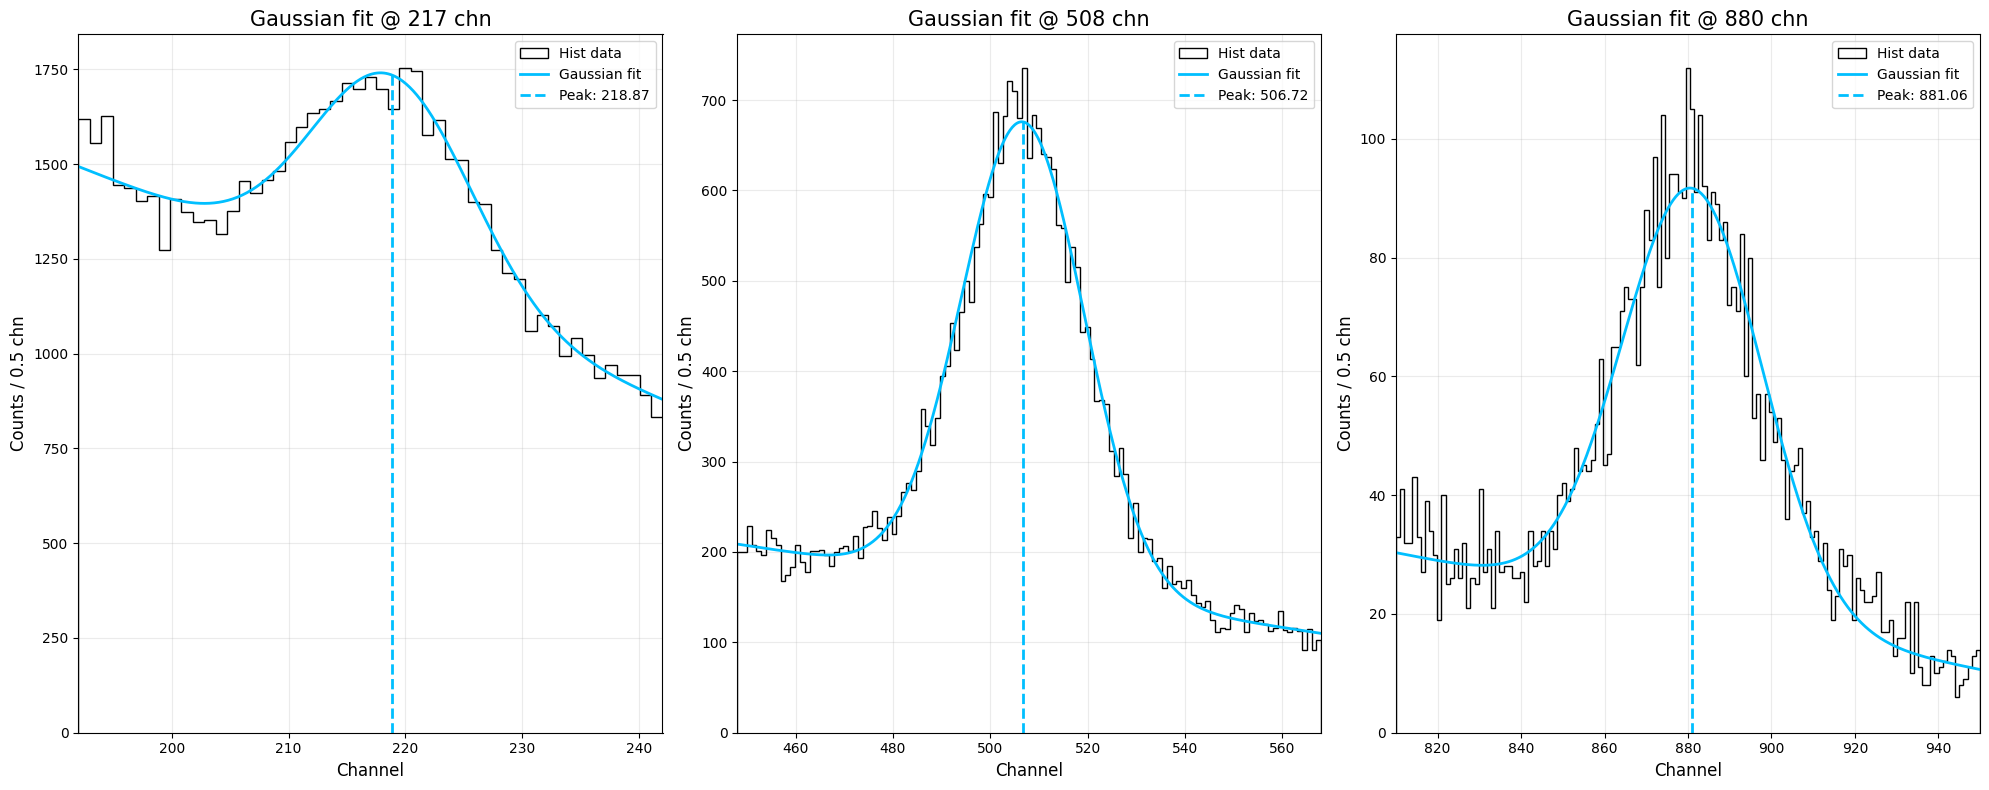

In [243]:
fig, axes = plt.subplots(1,3, figsize=(20, 8))  # 3 righe, 2 colonne

chn = [217, 508, 605, 745, 880]
chn = [217,  508,   880]
dx_arr = [25,  60,  70]
##chn = [  508,   880]
#dx_arr = [  60,  70]
popts = []
pcovs = []
axes = axes.flatten() 
for i, (e, dx) in enumerate(zip(chn, dx_arr)):
    #ax = axes[row, col]
    ax = axes[i]
    popt, pcov = fit_func_1(spectrum, e, dx=dx, ax=ax)
    print(popt)
    popts.append(popt)
    pcovs.append(pcov)

popts = np.vstack(popts) 
pcovs = np.vstack(pcovs)

plt.tight_layout()
plt.savefig("new NAI/peaks_chn_bkg_open", dpi=300, bbox_inches='tight')

plt.show()


In [213]:
popts

array([[ 5.72255990e+02,  2.18870460e+02,  6.83180629e+00,
         2.63143396e+03,  5.69025798e+02, -1.23227772e+01,
         3.85975841e+03],
       [ 5.15543979e+02,  5.06719626e+02,  1.25949703e+01,
         5.82568548e+03,  2.53853468e+02, -8.23558781e-01,
         5.77685369e+02],
       [ 7.13519649e+01,  8.81056943e+02,  1.67803512e+01,
         1.13037689e+05,  2.56318877e+05, -1.40624442e-01,
         1.44221092e+02]])

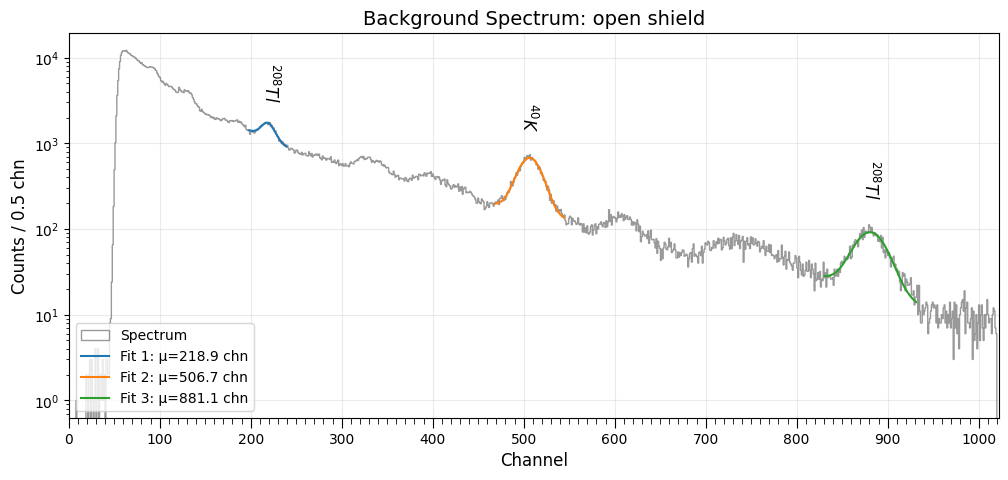

In [244]:
plt.figure(figsize=(12, 5))
dx = 100
dy = 10
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero

chn = np.arange(len(spectrum))  # canali da 0 a N-1
bins = np.linspace(min(chn), max(chn), int(len(chn))+1)
hist, bin_edge, _ = plt.hist(chn, bins = bins, weights= spectrum, color = 'grey', lw = 0.9, alpha = 0.8,  histtype='step', ec='k',label='Spectrum')
db = 0.5*(bin_edge[1]-bin_edge[0])
for i, popt in enumerate(popts):
    A, mu, sigma, a,b,c,d = popt

    if i == 0:
        x_fit = np.linspace(mu -3*sigma, mu +3*sigma, 300)
    else:
        x_fit = np.linspace(mu -3*sigma, mu +3*sigma, 300)
    y_fit = gaussian_offset(x_fit, *popt)
    plt.plot(x_fit, y_fit,  label=f'Fit {i+1}: μ={mu:.1f} chn')

plt.text(210 , 3.4e3, r"$^{208}Tl$", rotation=270,  size = 12)
plt.text(494 , 1.5e3, r'$^{40}K$', rotation=270,  size = 12)
plt.text(870 , 0.25e3, r'$^{208}Tl$', rotation=270,  size = 12)
plt.xlabel('Channel', size = 12)
plt.ylabel(f'Counts / {db:.1f} chn', size = 12)
plt.title('Background Spectrum: open shield', size = 14)
plt.xlim(0, len(spectrum))
plt.yscale('log')
plt.legend(loc = 'lower left')
plt.grid(alpha = 0.25)
plt.savefig("new NAI/spectrum_peak_fit_chn", dpi=300, bbox_inches='tight')


In [215]:
popts[:,1]

array([218.87045963, 506.71962552, 881.05694272])

In [253]:
def k_calibration(E,a,b):
    return E * a +b

fig, axes = plt.subplots(1, 3, figsize=(12, 5))  # 3 righe, 2 colonne

#chn = [217, 508, 605,  880]
chn = [217, 508,  880]
dx_arr = [15, 40, 40,  50]
popts = []
pcovs = []

for i, (e, dx) in enumerate(zip(chn, dx_arr)):
    row = i // 2
    col = i % 2
    ax = axes[i]
    popt, pcov = fit_func_1(spectrum, e, dx=dx, ax=ax)
    print(popt)
    popts.append(popt)
    pcovs.append(pcov)

popts = np.vstack(popts) 
pcovs = np.vstack(pcovs)

plt.savefig("NaI images/peaks_chn_background", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

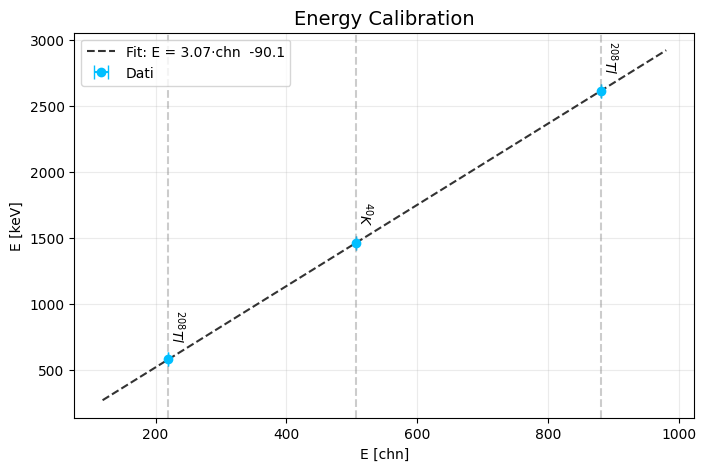

In [268]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Dati di esempio (assicurati di avere questi array già definiti nel tuo codice)
E_kev = [583, 1460.830,  2614]  # energia in keV
chn = [217, 508, 880]               # canali
isotopes = ["$^{208}Tl$", "$^{40}K$", "$^{208}Tl$"]

E_kev = [583.181, 1460.830,  2614]  # energia in keV
#chn = [ 508, 880]  

# Esegui la calibrazione (assumi che popts e pcovs siano già definiti)
plt.figure(figsize=(8, 5))
plt.errorbar(popts[:, 1], E_kev, xerr=pcovs[:, 1], fmt='o', capsize=5, color='deepskyblue', label='Dati')
xerr=pcovs[:, 1],
# Fit della calibrazione
p0 = [5, -1]
bounds = ([0,0], [100000,100000])
popt, pcov = curve_fit(k_calibration, popts[:, 1], E_kev, p0=p0)
perr = np.sqrt(np.diag(pcov))
a_bkg = popt[0]
b_bkg = popt[1]

# Visualizza le linee verticali e le etichette
for v, ene, name in zip(popts[:,1], E_kev, isotopes):
    plt.axvline(x=v, color='gray', linestyle='--', alpha=0.4)
    plt.text(v , ene + 150, name, rotation=270, size=10)

# Plot
x_fit = np.linspace(min(popts[:,1])-100, max(popts[:,1])+100, 500)
y_fit = k_calibration(x_fit, *popt)
plt.plot(x_fit, y_fit, label=f"Fit: E = {popt[0]:.2f}·chn  {popt[1]:.1f}", color='black', ls = '--', alpha = 0.8)

plt.legend()
plt.xlabel('E [chn]', size = 10)
plt.ylabel('E [keV]', size = 10)
plt.title('Energy Calibration', size = 14)
plt.savefig("new NAI/ene_cal_bkg_open", dpi=300, bbox_inches='tight')

plt.grid(alpha =0.25)

In [269]:
channels_bkg = np.arange(len(spectrum))         # x originale
energies_bkg = a_bkg * channels_bkg  + b_bkg


In [270]:
for i in range(0,len(energies_bkg)):
    if spectrum[i] != 0:
        print(f' Energy threshold at {energies_bkg[i] + 15 : .2f} keV' )
        break


 Energy threshold at -50.59 keV


In [257]:
perr

array([0.00890866, 5.3474991 ])

In [258]:
# a causa della risoluzione gigante del 4 picco lo abbiamo escluso

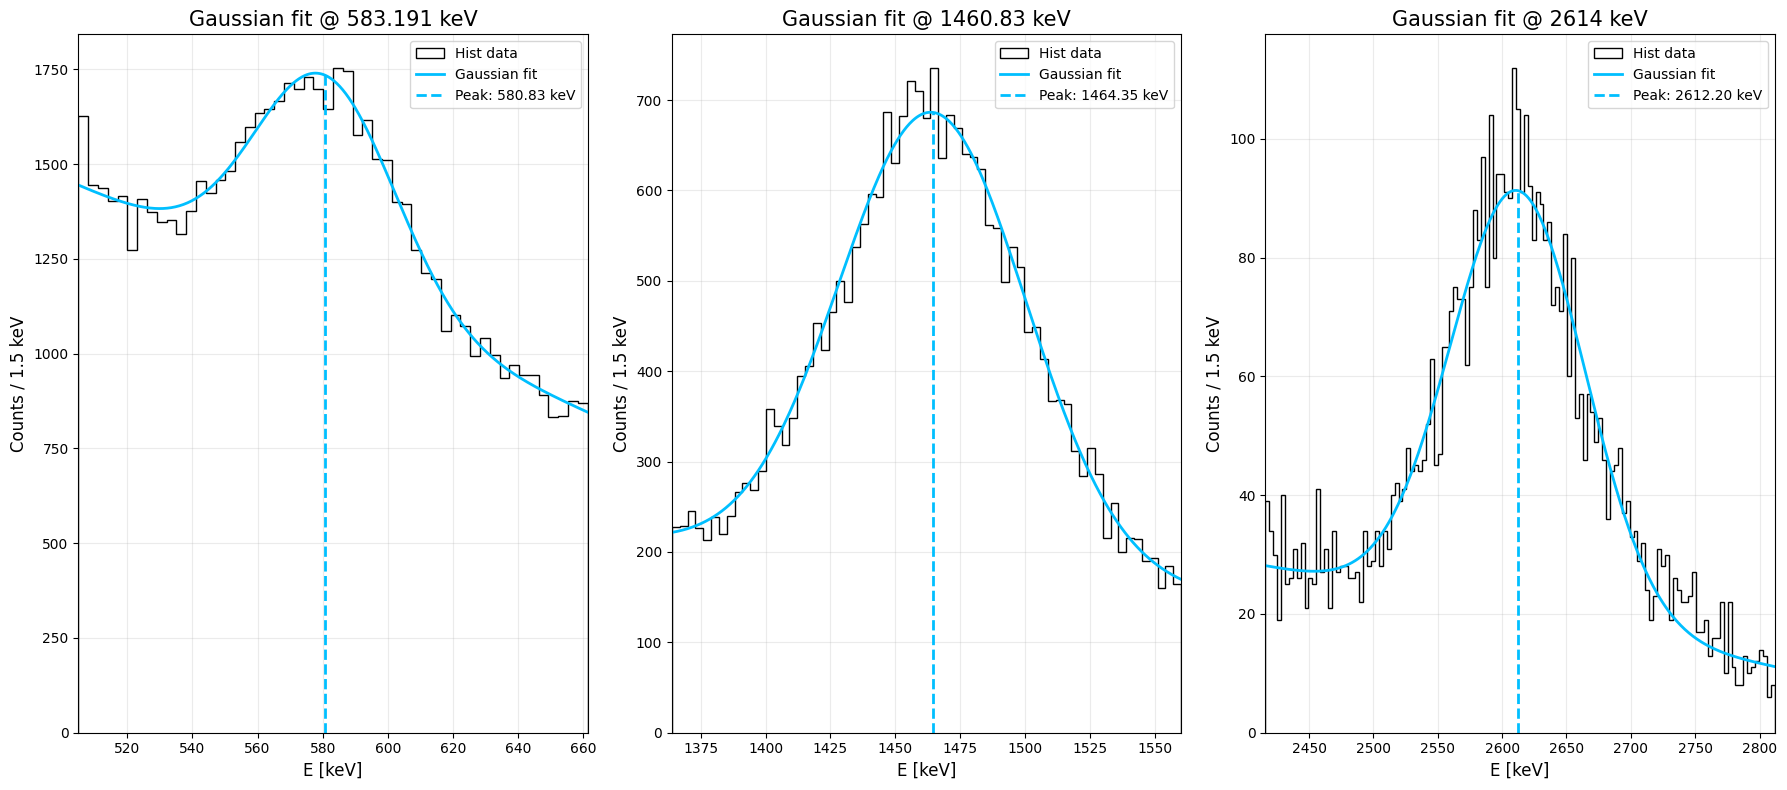

In [272]:
fig, axes = plt.subplots(1, 3, figsize=(18, 8))  # 3 righe, 2 colonne

E_kev = [583.191, 1460.830, 2614]
#E_kev = [1460.830, 2614]
popt_kev = []
popt_kev_err = []
dx_arr = [ 80, 100, 200]
axes = axes.flatten() 
for i,(e,dx) in enumerate(zip(E_kev, dx_arr)):

    ax = axes[i]
    popt, err = fit_func_1( spectrum, e, dx = dx, kev = True, energies = energies_bkg, ax = ax)
    popt_kev.append(popt)
    popt_kev_err.append(err)
popt_kev = np.vstack(popt_kev)
popt_kev_err = np.vstack(popt_kev_err)


plt.tight_layout()
plt.savefig("new NAI/spectrum_peak_fit_kev", dpi=300, bbox_inches='tight')

plt.show()

In [260]:
for i, p in enumerate(popt_kev):
    print(f"Fit {i+1}: shape = {np.shape(p)} --> {p}")

Fit 1: shape = (7,) --> [ 580.91763242  580.82521843   21.43181667  595.95755969  537.80613198
   -3.82699545 3376.44379218]
Fit 2: shape = (7,) --> [ 5.03811432e+02  1.46435088e+03  3.59760141e+01  8.16003886e+05
  2.35169414e+04 -2.86773123e-01  6.02571336e+02]
Fit 3: shape = (7,) --> [ 7.16352811e+01  2.61220005e+03  5.23636365e+01  8.49523773e+05
  2.25020844e+05 -4.29151535e-02  1.31755704e+02]


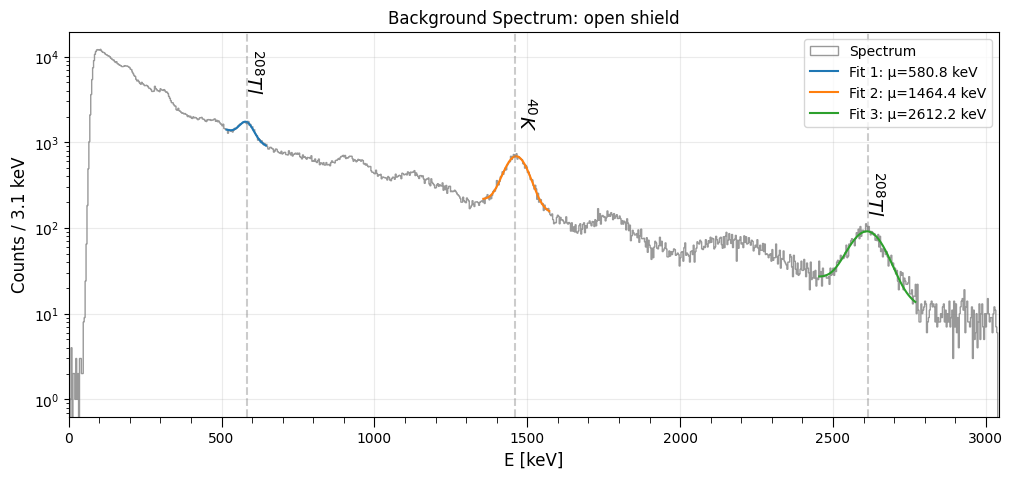

In [287]:
plt.figure(figsize=(12,5))

dx = 500
dy = 100
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero



chn = np.arange(len(spectrum))  # canali da 0 a N-1
bins = np.linspace(min(energies_bkg), max(energies_bkg), int(len(energies_bkg))+1)
hist, bin_edge, _ = plt.hist(energies_bkg, bins = bins, weights= spectrum, color = 'grey', lw = 0.9, alpha = 0.8,  histtype='step', ec='k',label='Spectrum')
db = (bin_edge[1]-bin_edge[0])
plt.xlabel('E [keV]', size = 12)
plt.ylabel(f'Counts / {db :.1f} keV', size = 12)
plt.title('Background Spectrum: open shield', size = 12)
plt.xlim(0, max(energies_bkg))
for i, popt in enumerate(popt_kev):
    A, mu, sigma, a,b,c,d = popt

    if i == 0:
        x_fit = np.linspace(mu -3*sigma, mu +3*sigma, 300)
    else:
        x_fit = np.linspace(mu -3*sigma, mu +3*sigma, 300)
    y_fit = gaussian_offset(x_fit, *popt)
    plt.plot(x_fit, y_fit,  label=f'Fit {i+1}: μ={mu:.1f} keV')
for v in E_kev:
     plt.axvline(x=v, color='gray', linestyle='--', alpha=0.4)
plt.text(2600,  0.15e3, r'$^{208}Tl$', rotation=270,  size = 14)
plt.text(1460, 1.5e3, r'$^{40}K$', rotation=270,  size = 14)
plt.text(569, 4e3, r"$^{208}Tl$", rotation=270,  size = 14)

#plt.vlines(75, 1,111111, color = 'red')
plt.yscale('log')
plt.legend()
plt.grid(alpha = 0.25)
plt.savefig("new NAI/ene_spectrum_kev_open_bkg", dpi=300, bbox_inches='tight')
plt.show()

In [288]:
energies_bkg = a_bkg * channels_bkg  + b_bkg
mask = (energies_bkg > 75) & (energies_bkg <= 3000)

spectr_3Mev = np.sum(spectrum[mask])
cps_total = spectr_3Mev/t_bk_open_live

print(f'count rate totale {cps_total:.0f} cps')

count rate totale 79 cps


incertezza grandi solo 3 punti del fit
paramters: [1.97409316 0.02682987]
Errori: [0.03315802 0.00141412]


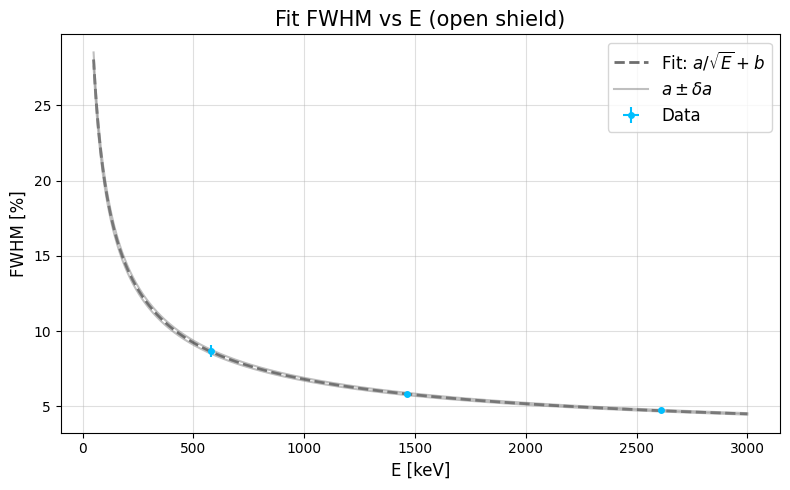

In [289]:
# Calcolo FWHM e incertezza
sigma= popt_kev[:,2]
sigma_err_kev=popt_kev_err[:,2]
mu_kev=popt_kev[:,1]
mu_kev_err =popt_kev_err[:,1]
FWHM, FWHM_err = fwhm_percentuale(sigma, sigma_err_kev, mu_kev, mu_kev_err)
# Fit con curve_fit, usando incertezza su y
boundary = ([0,
             0],[100,100])
p0=[3,0]
popt_res_open, pcov = curve_fit(fhwm_func, mu_kev, FWHM, sigma = FWHM_err,  p0=p0, bounds=boundary)
print('incertezza grandi solo 3 punti del fit')
print("paramters:", popt_res_open)
print("Errori:", np.sqrt(np.diag(pcov)))
perr = np.sqrt(np.diag(pcov))

# Preparazione plot
E_fit = np.linspace(50, (3000), 1000)

plt.figure(figsize=(8, 5))
plt.ylabel('FWHM [%]')
# Fit teorico
plt.plot(E_fit, fhwm_func(E_fit, *popt_res_open)*100, label=r'Fit: $a/\sqrt{E} + b$',color='black', ls = '--', alpha = 0.57, lw=2)
# Dati con errore su x e y, e stile pallini
plt.errorbar(mu_kev, FWHM*100,
             xerr=mu_kev_err,
             yerr=FWHM_err*100,
             fmt='o',  
             color = 'deepskyblue',              
             markersize=4,               # dimensione punto
             label='Data')

a_res_bkg= popt_res_open[0]
b_res_bkg  = popt_res_open[1]
perr_bkg_open = np.sqrt(np.diag(pcov))

# Traccia le due curve (come già fai)

upper_curve = fhwm_func(E_fit, a_res_bkg + perr_bkg_open[0], b_res_bkg) * 100
lower_curve = fhwm_func(E_fit, a_res_bkg - perr_bkg_open[0], b_res_bkg) * 100

plt.plot(E_fit, upper_curve,  color='gray', alpha=0.5, label=r"$a \pm \delta a$")
plt.plot(E_fit, lower_curve, color='gray', alpha=0.5)



# Etichette
plt.xlabel('E [keV]', size = 12)
plt.ylabel('FWHM [%]', size = 12)
plt.title('Fit FWHM vs E (open shield)', size = 15)
plt.grid(alpha=0.4)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.savefig("new NAI/FWHM_bkg_open", dpi=300, bbox_inches='tight')

plt.show()
plt.show()

In [290]:
(0.10575388 *100)/2.06911651 

5.111064528695873

# Background Shield

In [294]:
max(spectrum)

np.int64(504)

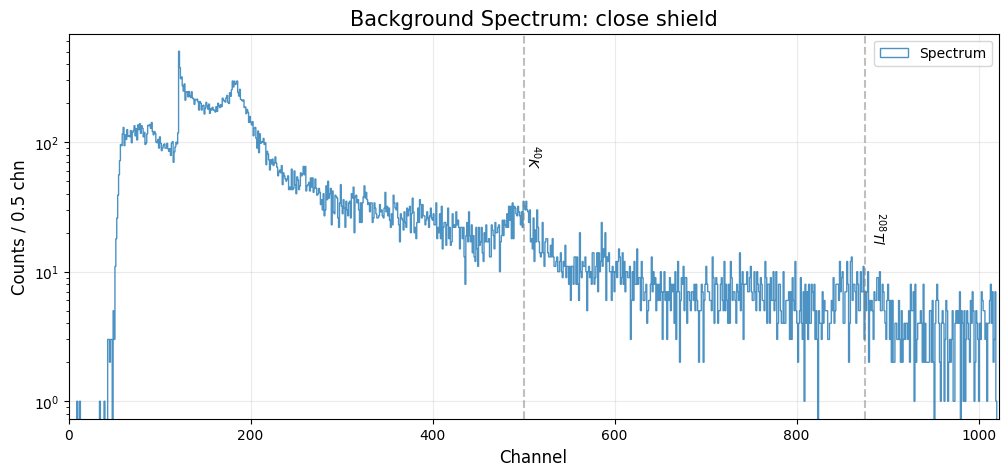

In [295]:
file_path = "bkg-shield.csv"
data = pd.read_csv(file_path, header=None)

# Ensure data is 1D (each count per channel/bin)
spectrum = data[0].values
chn = [ 500, 875]
plt.figure(figsize=(12,5))
chn_op = np.arange(len(spectrum))  # canali da 0 a N-1
bins = np.linspace(min(chn_op), max(chn_op), int(len(chn_op))+1)
hist, bin_edge, _ = plt.hist(chn_op, bins = bins, weights= spectrum, lw = 0.9, alpha = 0.8,  histtype='step', ec='k',label='Spectrum')
db = 0.5*(bin_edge[1]-bin_edge[0])
plt.xlabel('Channel', size = 12)
plt.ylabel(f'Counts / {db:.1f} chn', size = 12)
plt.title('Background Spectrum: close shield', size = 15)
plt.text(500, 6.5e1, r'$^{40}K$', rotation=270,  size = 10)
plt.text(880,1.7e1, r'$^{208}Tl$', rotation=270,  size = 10)
for v in chn:
    plt.axvline(x = v, alpha = 0.5, color = 'gray', ls = '--')
plt.xlim(0, len(spectrum))
plt.yscale('log')
plt.legend()
plt.grid(alpha = 0.25)
plt.savefig("new NAI/chn_background_close_shield", dpi=300, bbox_inches='tight')

plt.show()

[ 1.42081128e+01  4.95999773e+02  1.31858325e+01  2.15715986e+04
  7.87170019e+02 -6.39354853e-02  4.58591063e+01]
[ 2.65707885e+00  8.67659606e+02  2.22121468e+01  5.55293409e+04
  5.26425672e+05 -1.02698796e-02  1.24736820e+01]


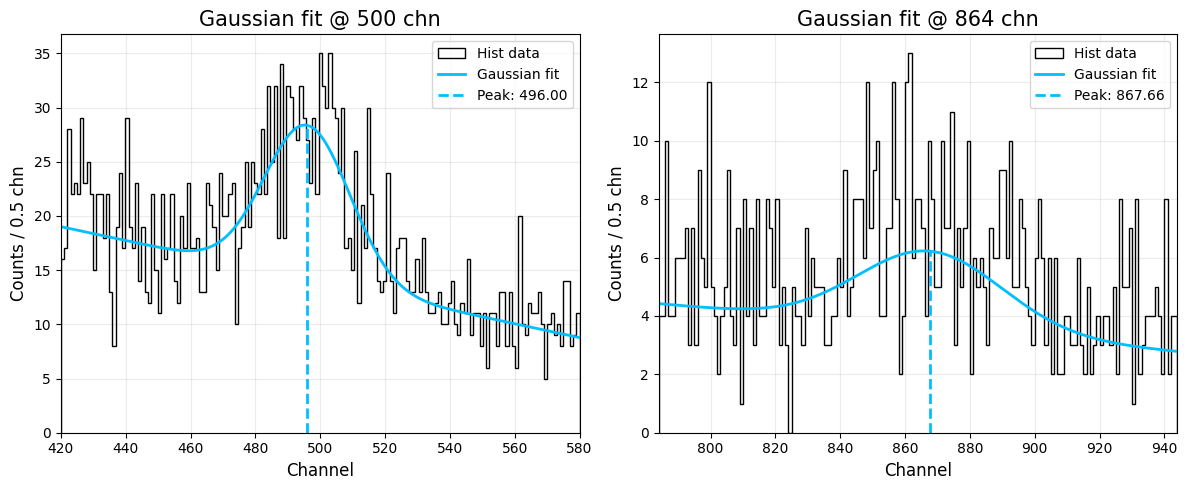

In [296]:
#chn = [ 185, 500, 864]
chn = [ 500, 864]
dx_arr = [ 80,80]
popts = []
pcovs = []

fig, axes = plt.subplots(1, 2, figsize=(12, 5)) 
for i, (e,dx) in enumerate(zip(chn,dx_arr)):
    popt, pcov = fit_func_1(spectrum, e, dx = dx,ax=axes[i])
    print(popt)
    popts.append(popt)
    pcovs.append(pcov)
popts = np.vstack(popts) 
pcovs = np.vstack(pcovs)
plt.savefig("new NAI/chn_peak_open_bkg", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

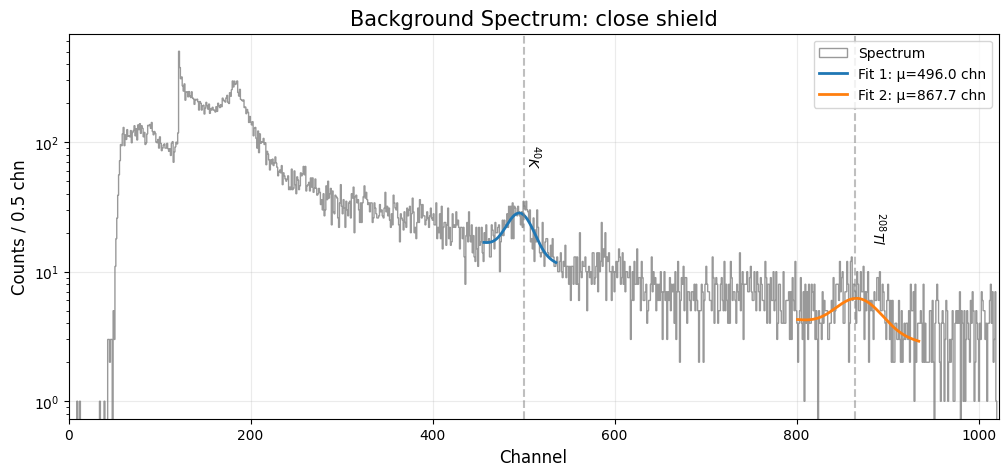

In [297]:
plt.figure(figsize=(12, 5))
chn_op = np.arange(len(spectrum))  # canali da 0 a N-1
bins = np.linspace(min(chn_op), max(chn_op), int(len(chn_op))+1)
hist, bin_edge, _ = plt.hist(chn_op, bins = bins, weights= spectrum, color = 'grey', lw = 0.9, alpha = 0.8,  histtype='step', ec='k',label='Spectrum')
db = 0.5*(bin_edge[1]-bin_edge[0])
for i, popt in enumerate(popts):
    A, mu, sigma, a,b,c,d= popt
    x_fit = np.linspace(mu - 3*sigma, mu + 3*sigma, 300)
    y_fit = gaussian_offset(x_fit, *popt)
    
    plt.plot(x_fit, y_fit, lw = 2, label=f'Fit {i+1}: μ={mu:.1f} chn')
for v in chn:
    plt.axvline(x = v, alpha = 0.5, color = 'gray', ls = '--')
plt.text(500, 6.5e1, r'$^{40}K$', rotation=270,  size = 10)
plt.text(880,1.7e1, r'$^{208}Tl$', rotation=270,  size = 10)
plt.xlabel('Channel', size = 12)
plt.ylabel(f'Counts / {db:.1f} chn', size = 12)

plt.title('Background Spectrum: close shield', size = 15)
plt.xlim(0, len(spectrum))
plt.yscale('log')
plt.legend()
plt.grid(alpha = 0.25)
plt.savefig("new NAI/fit_chn_open_bkg", dpi=300, bbox_inches='tight')
plt.show()

In [298]:
pcovs[0]

array([1.33878749e+00, 1.29018392e+00, 1.34346833e+00, 4.13596121e-16,
       0.00000000e+00, 6.66511771e-03, 3.48122381e+00])

/tmp/ipykernel_2009/1087694110.py:9: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(k_calibration, popts[:, 1], E_kev, p0=p0 )


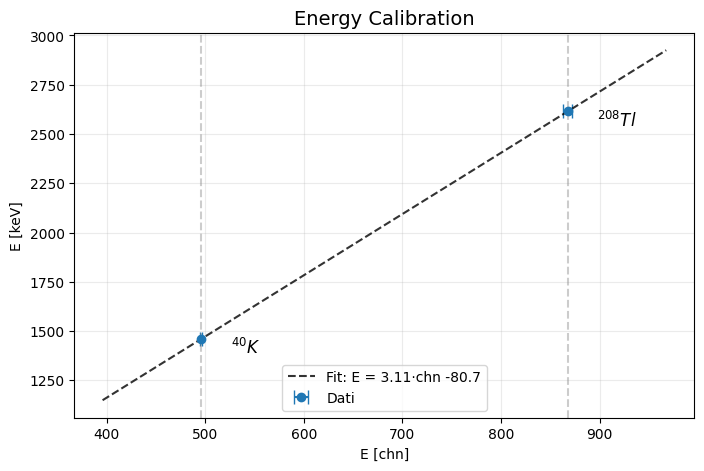

In [299]:
E_kev = [511, 1460, 2614.5] #kev
E_kev = [ 1460, 2614.5] #kev
isotopes = ["$^{40}K$","$^{208}Tl$"]

plt.figure(figsize = (8,5))
plt.errorbar( popts[:, 1],E_kev, xerr=pcovs[:, 1], fmt='o', capsize=5, label='Dati')

p0 = [5, -1 ]
popt, pcov = curve_fit(k_calibration, popts[:, 1], E_kev, p0=p0 )
# Incertezze
perr = np.sqrt(np.diag(pcov))
a_bkg_close = popt[0]
b_bkg_close = popt[1]
# Visualizza le linee verticali e le etichette
for v, ene, name in zip(popts[:, 1], E_kev, isotopes):
    plt.axvline(x=v, color='gray', linestyle='--', alpha=0.4)
    plt.text(v + 30, ene - 75, name, rotation=0, size=12)
# Plot
x_fit = np.linspace(min(popts[:,1])-100, max(popts[:,1])+100, 500)
y_fit = k_calibration(x_fit, *popt)
plt.plot(x_fit, y_fit, label=f"Fit: E = {popt[0]:.2f}·chn {popt[1]:.1f}", color='black', ls = '--', alpha = 0.8)

plt.legend()
plt.xlabel('E [chn]', size = 10)
plt.ylabel('E [keV]', size = 10)
plt.title('Energy Calibration', size = 14)
plt.grid(alpha =0.25)
plt.savefig("new NAI/cal_open_bkg", dpi=300, bbox_inches='tight')

In [300]:
popt

array([  3.10633514, -80.74152518])

In [301]:
perr

array([inf, inf])

In [302]:
channels_bkg = np.arange(len(spectrum))         # x originale
energies_bkg_close = a_bkg_close * channels_bkg  + b_bkg_close


In [304]:

mask = (energies_bkg_close >  75) & (energies_bkg_close < 3000)

spectr_3Mev = spectrum[mask]
cps_total = np.sum(spectr_3Mev)/(t_bk_closed_real)

print(f'count rate totale {cps_total:.0f} cps')

count rate totale 4 cps


In [305]:
(1-4/80)*100

95.0

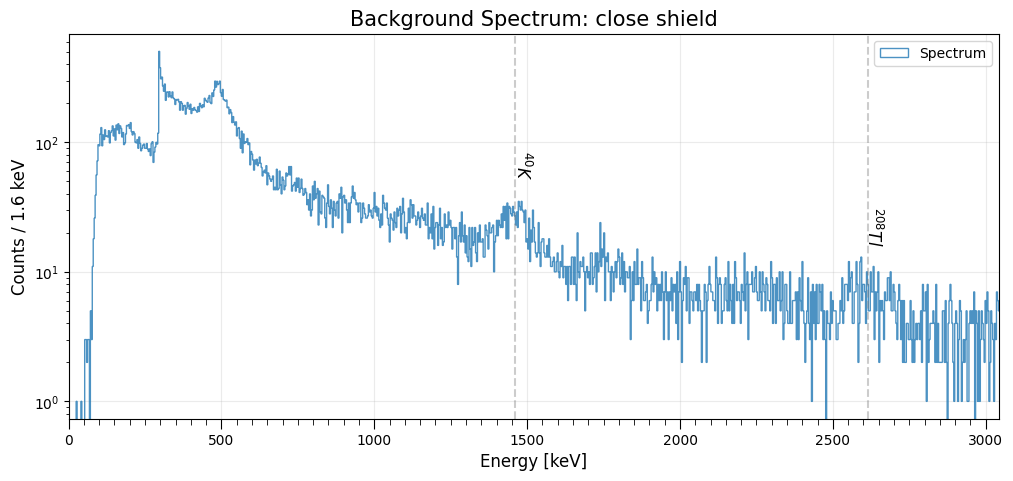

In [40]:
plt.figure(figsize=(12,5))
dx = 500
dy = 50
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero

chn = np.arange(len(spectrum))  # canali da 0 a N-1
bins = np.linspace(min(energies_bkg_close), max(energies_bkg_close), int(len(energies_bkg_close))+1)
hist, bin_edge, _ = plt.hist(energies_bkg_close, bins = bins, weights= spectrum, lw = 0.8, alpha = 0.8,  histtype='step', ec='k',label='Spectrum')
db = 0.5*(bin_edge[1]-bin_edge[0])
plt.xlabel('Energy [keV]', size = 12)
plt.ylabel(f'Counts / {db:.1f} keV', size = 12)
for v in E_kev:
     plt.axvline(x=v, color='gray', linestyle='--', alpha=0.4)
plt.title('Background Spectrum: close shield', size = 15)
plt.xlim(0, max(energies_bkg))
plt.text(1450, 5.5e1, r'$^{40}K$', rotation=270,  size = 12)
plt.text(2600,1.7e1, r'$^{208}Tl$', rotation=270,  size = 12)
plt.yscale('log')
plt.legend()
plt.grid(alpha = 0.25)
plt.savefig("new NAI/close_bkg_kev_soec", dpi=300, bbox_inches='tight')
plt.show()

[ 1.41674510e+01  1.45903755e+03  4.03435881e+01  1.58582640e+05
  1.21299173e+06 -1.80631400e-02  4.06313634e+01]
[ 2.20660304e+00  2.62056327e+03  5.88312284e+01  1.27879636e+04
  2.54601150e+03 -4.88852199e-03  1.67969211e+01]


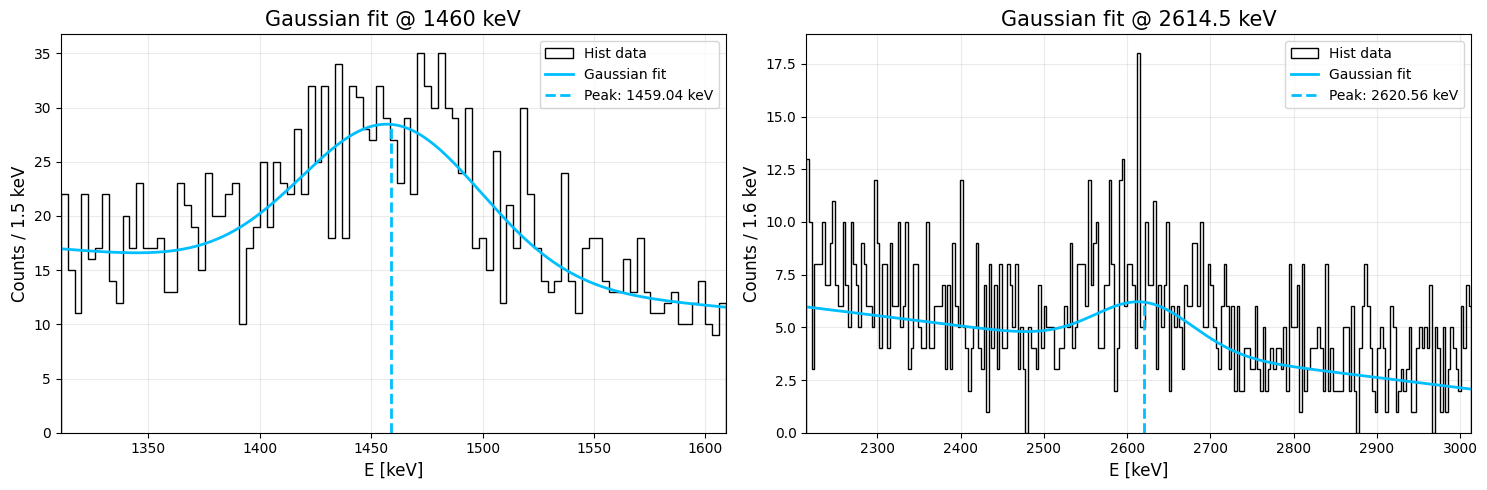

In [41]:
popt_kev = []
popt_kev_err = []
dx_arr = [50, 150, 400]
dx_arr = [ 150, 400]
fig, axes = plt.subplots(1, 2, figsize=(15, 5)) 
for i, (e,dx) in enumerate(zip(E_kev,dx_arr)):
    popt, err = fit_func_1( spectrum, e, dx = dx, kev = True, energies = energies_bkg_close,ax=axes[i])
    print(popt)
    popt_kev.append(popt)
    popt_kev_err.append(err)
popt_kev = np.vstack(popt_kev)
popt_kev_err = np.vstack(popt_kev_err)
plt.tight_layout()
plt.savefig("new NAI/ene_peaks_fit_cs", dpi=300, bbox_inches='tight')
plt.show()

In [42]:
for i in range(0, len(popt_kev[:,1])):
    mu_kev = popt_kev[:,1]
    mu_kev_err = popt_kev_err[:,1]
    mu_theo = E_kev[i]
    mu_exo = mu_kev[i]
    err = mu_kev_err[i]
    _ = t_test_theoretical(mu_exo,err,mu_theo)

t = -0.23
✅ p > 0.05 
p-value = 0.8577
t = 0.39
✅ p > 0.05 
p-value = 0.7624


incertezza grandi solo 3 punti del fit
paramters: [2.18107926 0.0313029 ]
Errori: [inf inf]


/tmp/ipykernel_2009/1187196476.py:10: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_res_close, pcov = curve_fit(fhwm_func, mu_kev, FWHM, sigma = FWHM_err,  p0=p0, bounds=boundary)


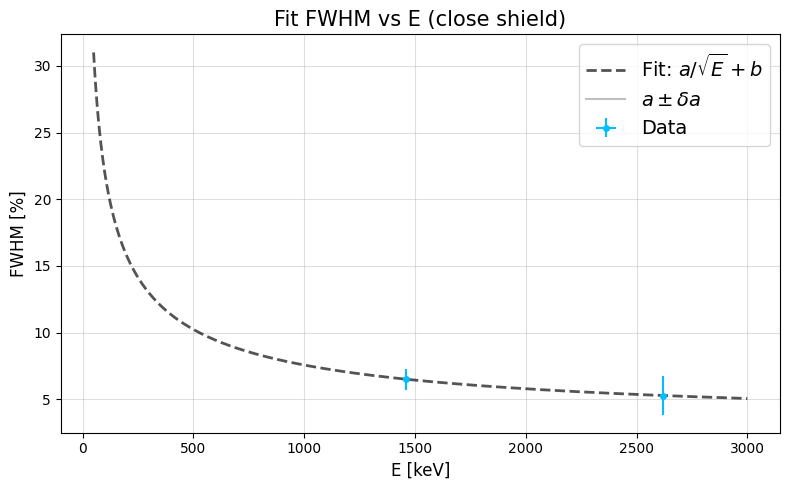

In [43]:
# Calcolo FWHM e incertezza
sigma= popt_kev[:,2]
sigma_err_kev=popt_kev_err[:,2]
mu_kev=popt_kev[:,1]
mu_kev_err =popt_kev_err[:,1]
FWHM, FWHM_err = fwhm_percentuale(sigma, sigma_err_kev, mu_kev, mu_kev_err)
# Fit con curve_fit, usando incertezza su y
boundary = ([0,0],[10000,10000])
p0=[3,0]
popt_res_close, pcov = curve_fit(fhwm_func, mu_kev, FWHM, sigma = FWHM_err,  p0=p0, bounds=boundary)
print('incertezza grandi solo 3 punti del fit')
print("paramters:", popt_res_close)
print("Errori:", np.sqrt(np.diag(pcov)))

# Preparazione plot
E_fit = np.linspace(50, (3000), 1000)
plt.figure(figsize=(8, 5))
plt.ylabel('FWHM [%]')
# Fit teorico
plt.plot(E_fit, fhwm_func(E_fit, *popt_res_close)*100, label=r'Fit: $a/\sqrt{E} + b$',color='black', ls = '--', alpha = 0.67, lw=2)
# Dati con errore su x e y, e stile pallini
plt.errorbar(mu_kev, FWHM*100,
             xerr=mu_kev_err,
             yerr=FWHM_err*100,
             fmt='o',  
             color = 'deepskyblue',              
             markersize=4,               # dimensione punto
             label='Data')

a_res_bkg_close = popt_res_close[0]
b_res_bkg_close  = popt_res_close[1]

perr = np.sqrt(np.diag(pcov))

upper_curve = fhwm_func(E_fit, a_res_bkg_close + perr[0], b_res_bkg_close) * 100
lower_curve = fhwm_func(E_fit, a_res_bkg_close - perr[0], b_res_bkg_close) * 100

plt.plot(E_fit, upper_curve,  color='gray', alpha=0.5, label=r"$a \pm \delta a$")
plt.plot(E_fit, lower_curve, color='gray', alpha=0.5)



# Etichette
plt.xlabel('E [keV]', size = 12)
plt.ylabel('FWHM [%]', size = 12)
plt.title('Fit FWHM vs E (close shield)', size = 15)
plt.grid(alpha=0.4)
plt.legend(fontsize = 14)
plt.tight_layout()
plt.savefig("NaI images/resolution_cose_shield", dpi=300, bbox_inches='tight')
plt.show()

# confronto risoluzioni enrgetiche solo background

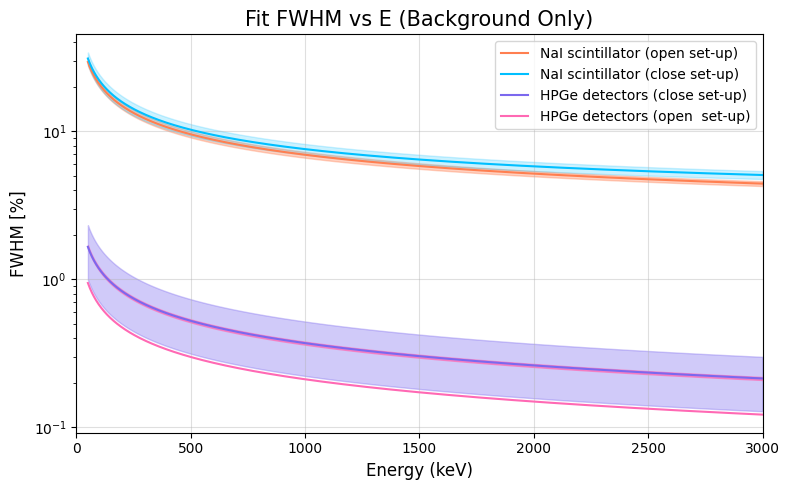

In [44]:
plt.figure(figsize=(8, 5))
plt.ylabel('FWHM [%]')
# Fit teorico
E_fit = np.linspace(50, (3000), 1000)
plt.plot(E_fit, fhwm_func(E_fit, a_res_bkg,b_res_bkg)*100, color = 'coral', label=r'NaI scintillator (open set-up)')
upper_curve = fhwm_func(E_fit, a_res_bkg + perr_bkg_open[0], b_res_bkg) * 100
lower_curve = fhwm_func(E_fit, a_res_bkg - perr_bkg_open[0], b_res_bkg) * 100
plt.fill_between(E_fit, lower_curve, upper_curve, color='coral', alpha=0.35)



plt.plot(E_fit, fhwm_func(E_fit, a_res_bkg_close,b_res_bkg_close )*100, color = 'deepskyblue', label=r'NaI scintillator (close set-up)')
upper_curve = fhwm_func(E_fit, a_res_bkg_close + 0.1*a_res_bkg_close,b_res_bkg_close) * 100
lower_curve = fhwm_func(E_fit, a_res_bkg_close - 0.1*a_res_bkg_close,b_res_bkg_close) * 100
plt.fill_between(E_fit, lower_curve, upper_curve, color='deepskyblue', alpha=0.2)




plt.plot(E_fit, fhwm_func(E_fit, 1.17230316e-01, 1.48919993e-17)*100,color = 'mediumslateblue',  label=r'HPGe detectors (close set-up)')
upper_curve = fhwm_func(E_fit, 1.17230316e-01 - 4.68435629e-02, 1.48919993e-17) * 100
lower_curve = fhwm_func(E_fit, 1.17230316e-01 + 4.68435629e-02, 1.48919993e-17) * 100
plt.fill_between(E_fit, lower_curve, upper_curve, color='mediumslateblue', alpha=0.35)

2.71598381e-03
plt.plot(E_fit, fhwm_func(E_fit, 6.68224115e-02 , 6.18902280e-17)*100,color = 'hotpink',  label=r'HPGe detectors (open  set-up)')
upper_curve = fhwm_func(E_fit, 1.17230316e-01 - 2.71598381e-03, 1.48919993e-17) * 100
lower_curve = fhwm_func(E_fit, 1.17230316e-01 + 2.71598381e-03, 1.48919993e-17) * 100
plt.fill_between(E_fit, lower_curve, upper_curve, color='hotpink', alpha=0.65)
plt.xlim(0,3000)
# Etichette
plt.xlabel('Energy (keV)', size = 12)
plt.ylabel('FWHM [%]', size = 12)
plt.title('Fit FWHM vs E (Background Only)', size = 15)
plt.grid(alpha=0.4)
plt.legend()
plt.yscale('log')
plt.tight_layout()
plt.savefig("new NAI/confronto_background", dpi=300, bbox_inches='tight')
plt.show()

# Lense Shield CLOSED

In [160]:
t_lense_closed_live

862

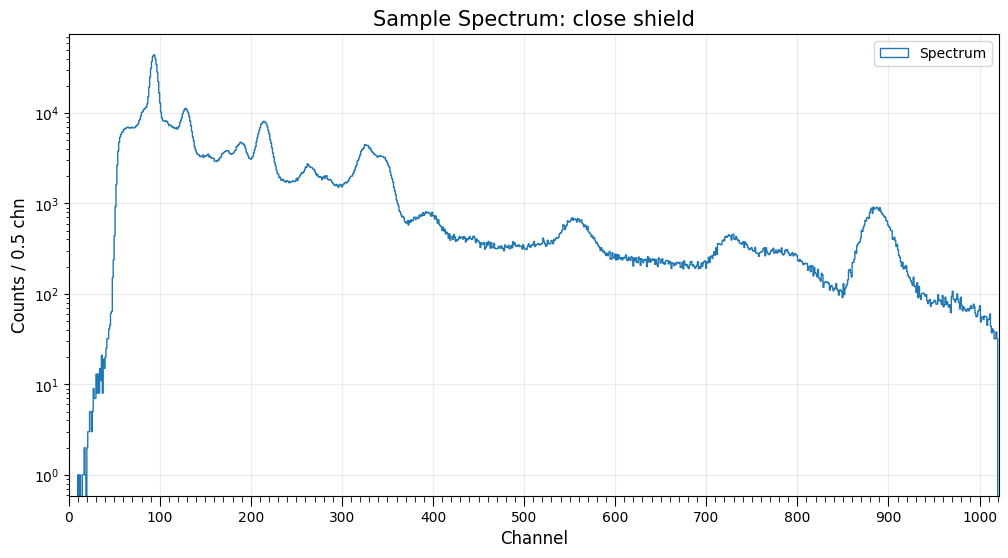

In [45]:
file_path = "lense_closed.csv"
data = pd.read_csv(file_path, header=None)

# Ensure data is 1D (each count per channel/bin)
spectrum_clos_lense = data[0].values
#spectrum_clos_lense = spectrum/(1- (t_lense_closed_live/t_lense_closed_real))

plt.figure(figsize=(12, 6))
dx = 100
dy = 10
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero

chn = np.arange(len(spectrum_clos_lense))  # canali da 0 a N-1
bins = np.linspace(min(chn), max(chn), int(len(chn))+1)
hist, bin_edge, _ = plt.hist(chn, bins = bins, weights= spectrum_clos_lense, histtype='step', ec='k',label='Spectrum')
db = 0.5*(bin_edge[1]-bin_edge[0])
plt.xlim(0, max(chn))
plt.ylabel(f'Counts / {db:.1f} chn', size = 12)
#plt.hist(chn, bins = len(spectrum), weights= spectrum,label='Spectrum')
plt.xlabel('Channel', size = 12)
plt.title('Sample Spectrum: close shield', size = 15)
plt.yscale('log')
plt.legend()
plt.grid(alpha =0.25)
plt.show()

In [46]:
energies_bkg = a_bkg * channels_bkg  + b_bkg
mask = (energies_bkg > min(energies_bkg)) & (energies_bkg < 3000)

spectr_3Mev = spectrum[mask]
cps_total = np.sum(spectrum_clos_lense)/(t_lense_open_real)

print(f'count rate totale {cps_total:.0f} cps')

count rate totale 1708 cps


In [47]:
395-128

267

In [48]:
555-395

160

[ 3.53186576e+04  9.33722193e+01  3.31741558e+00  1.11404426e+03
  2.54755221e-02 -1.47957624e+02  2.28746860e+04]
[ 6.27416858e+03  1.28680933e+02  4.38713748e+00  2.31537706e+02
  5.68611525e+01 -1.33035084e+02  2.19882633e+04]
[ 5.79385222e+03  2.14257671e+02  6.02632264e+00  1.79690780e+03
  7.63736561e+01 -2.68334764e+01  8.05300083e+03]
[ 2.83947377e+03  3.27222960e+02  8.38609750e+00  5.27525860e+06
  1.04523914e+07 -1.17948371e-10  1.53992494e+03]
[ 3.83042523e+02  5.56158804e+02  1.33290119e+01  1.86697762e+04
  1.52457593e+03 -3.10774141e-02  3.06732718e+02]
[ 3.25053120e+02  7.29299041e+02  1.95175983e+01  2.09612225e+05
  2.55584667e+05 -8.94385063e-14  9.99050245e+01]
[ 7.71372339e+02  8.87655546e+02  1.36449573e+01  2.79224645e+06
  6.43828163e+05 -1.76557433e-17  1.03149222e+02]


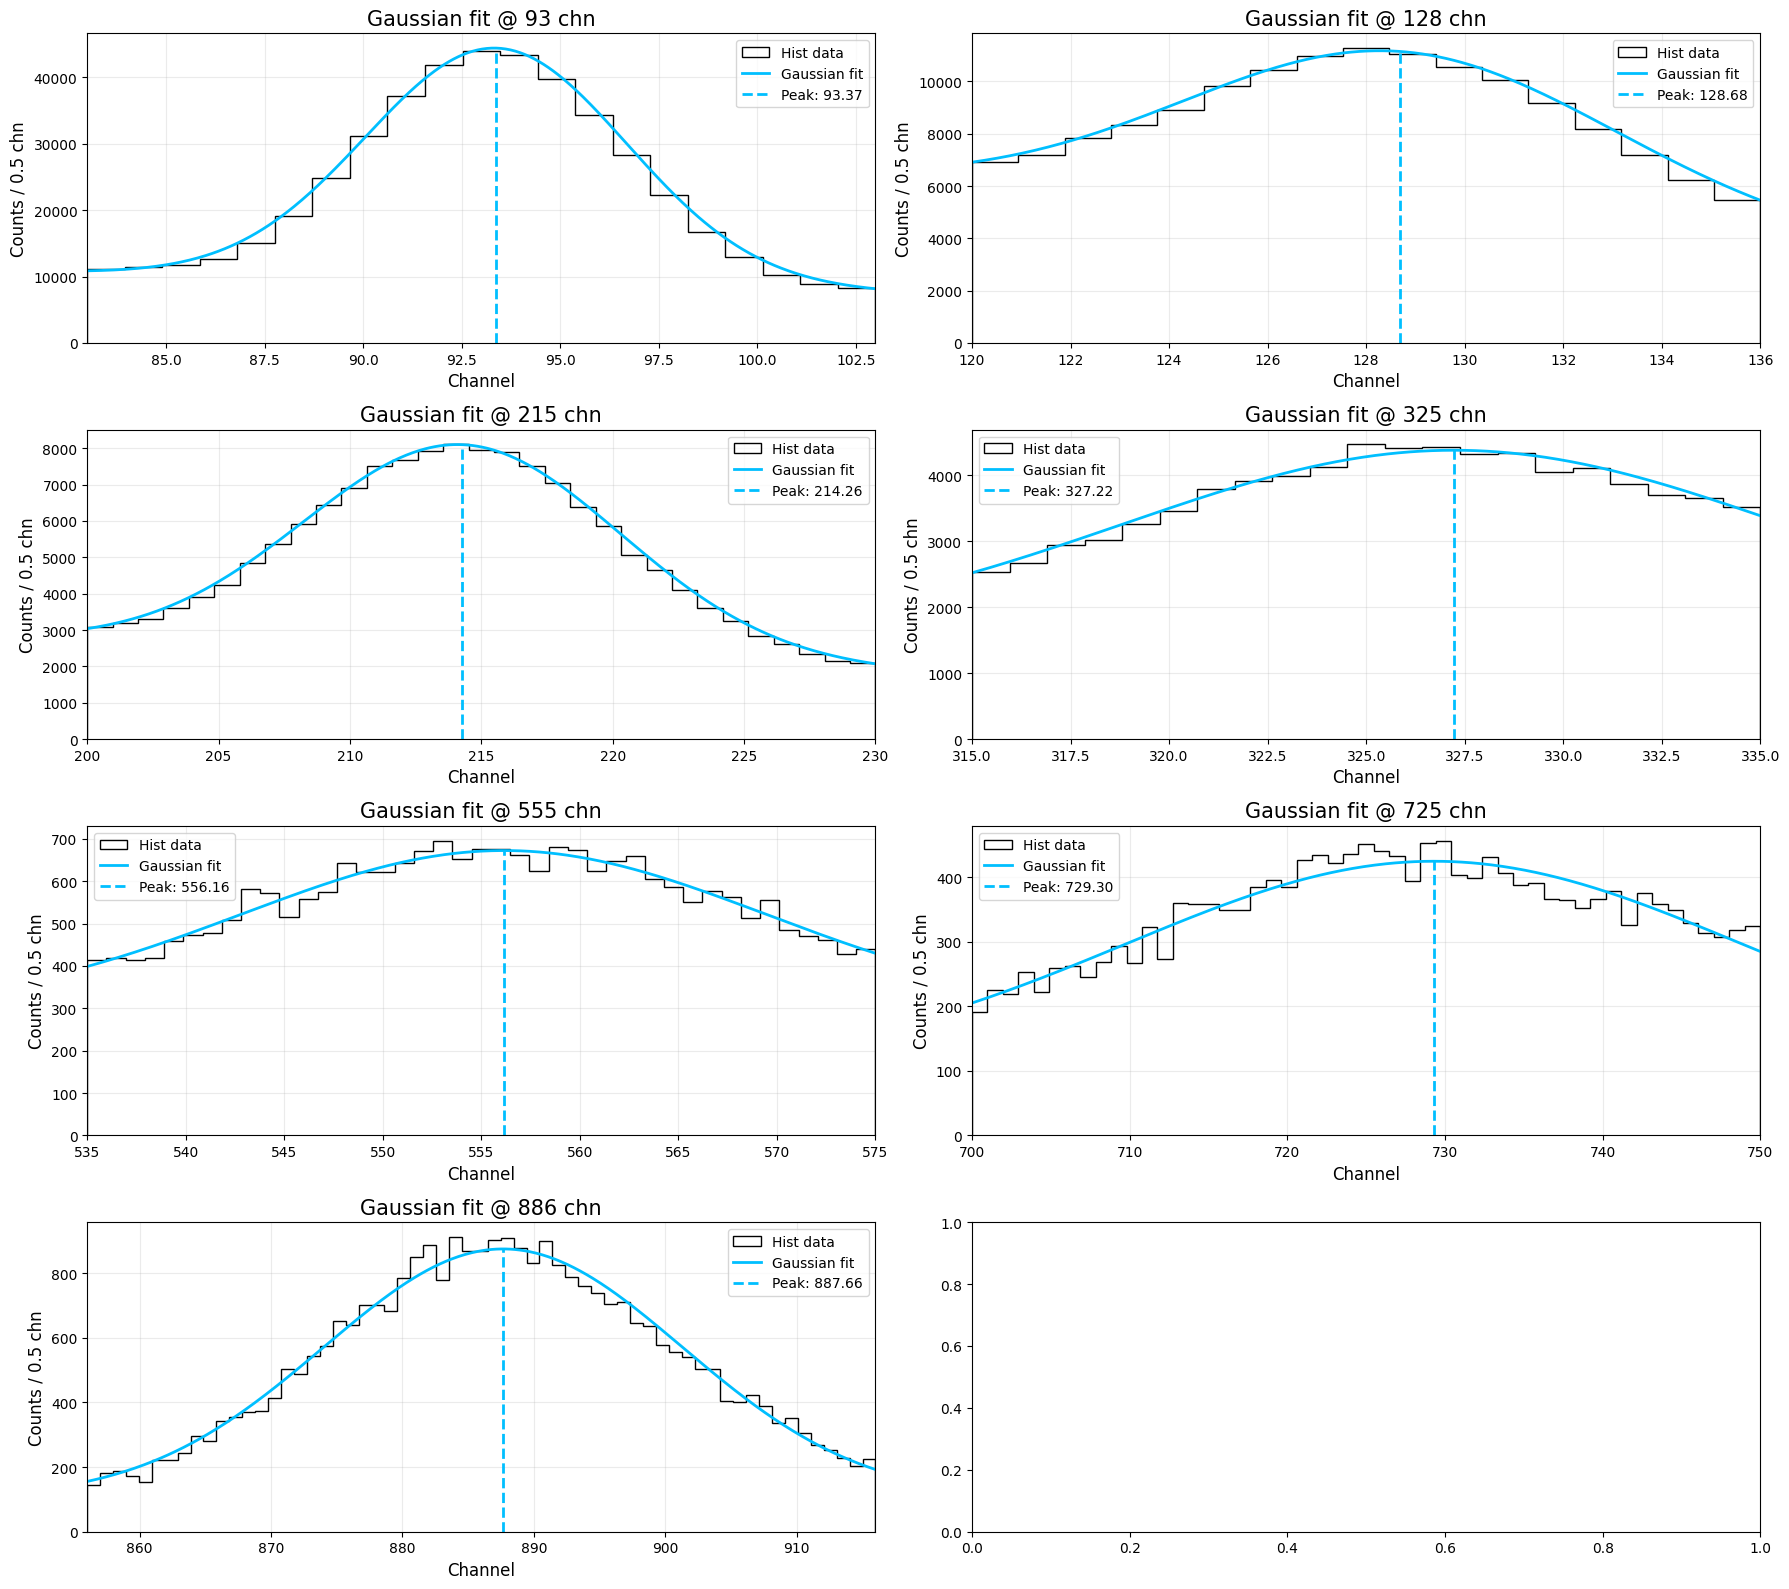

In [49]:
#chn = [93, 128, 189, 215, 263, 395, 555,  886]
#dx_arr = [20,25,10,15,20,20,20,20]
chn = [ 128,215,395, 555, 725, 886]
chn = [93, 128, 215, 325,  555,725,  886]
dx_arr = [10,8,15,10, 20,25,30,50]
popts = []
pcovs = []

fig, axes = plt.subplots(4, 2, figsize=(18, 16))  # 3 righe, 2 colonne
for i,(e,dx) in enumerate(zip(chn,dx_arr)):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    popt, pcov = fit_func_1(spectrum_clos_lense, e, dx = dx, ax = ax)
    print(popt)
    popts.append(popt)
    pcovs.append(pcov)
popts = np.vstack(popts) 
pcovs = np.vstack(pcovs)

# Disattiva assi inutilizzati se i subplot sono di più degli elementi
for j in range(len(chn),4 ):
    row = j // 2
    col = j % 2
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [50]:
popts

array([[ 3.53186576e+04,  9.33722193e+01,  3.31741558e+00,
         1.11404426e+03,  2.54755221e-02, -1.47957624e+02,
         2.28746860e+04],
       [ 6.27416858e+03,  1.28680933e+02,  4.38713748e+00,
         2.31537706e+02,  5.68611525e+01, -1.33035084e+02,
         2.19882633e+04],
       [ 5.79385222e+03,  2.14257671e+02,  6.02632264e+00,
         1.79690780e+03,  7.63736561e+01, -2.68334764e+01,
         8.05300083e+03],
       [ 2.83947377e+03,  3.27222960e+02,  8.38609750e+00,
         5.27525860e+06,  1.04523914e+07, -1.17948371e-10,
         1.53992494e+03],
       [ 3.83042523e+02,  5.56158804e+02,  1.33290119e+01,
         1.86697762e+04,  1.52457593e+03, -3.10774141e-02,
         3.06732718e+02],
       [ 3.25053120e+02,  7.29299041e+02,  1.95175983e+01,
         2.09612225e+05,  2.55584667e+05, -8.94385063e-14,
         9.99050245e+01],
       [ 7.71372339e+02,  8.87655546e+02,  1.36449573e+01,
         2.79224645e+06,  6.43828163e+05, -1.76557433e-17,
         1.0314922

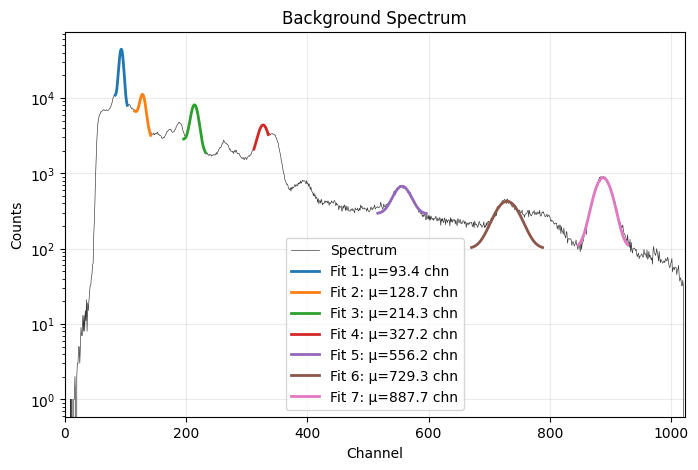

In [51]:
plt.figure(figsize=(8, 5))
plt.plot(spectrum_clos_lense, color = 'black', lw = 0.46, alpha = 0.8, label='Spectrum')
for i, popt in enumerate(popts):
    A, mu, sigma, a,b,c,d = popt
    if i ==  3:
        x_fit = np.linspace(mu - 1.8*sigma, mu + sigma, 300)
    else:
        x_fit = np.linspace(mu - 3*sigma, mu + 3*sigma, 300)
    y_fit = gaussian_offset(x_fit, *popt)
    plt.plot(x_fit, y_fit, lw = 2,  label=f'Fit {i+1}: μ={mu:.1f} chn')


plt.xlabel('Channel')
plt.ylabel('Counts')
plt.title('Background Spectrum')
plt.xlim(0, len(spectrum_clos_lense))
plt.yscale('log')
plt.legend()
plt.grid(alpha = 0.25)
plt.show()

In [52]:
def k_calibration(E,a,b):
    return E * a +b

In [53]:
2614-511-511

1592

In [54]:
#E_kev_lc = [209, 338.32,511, 662, 727.330, 1120.287, 1588.190,  2614] #kev
E_kev_lc = [  240, 511,  1063, 1592, 2103, 2614] #kev
E_kev_lc = [   238, 338, 583,  968, 1592, 2103, 2614] #kev

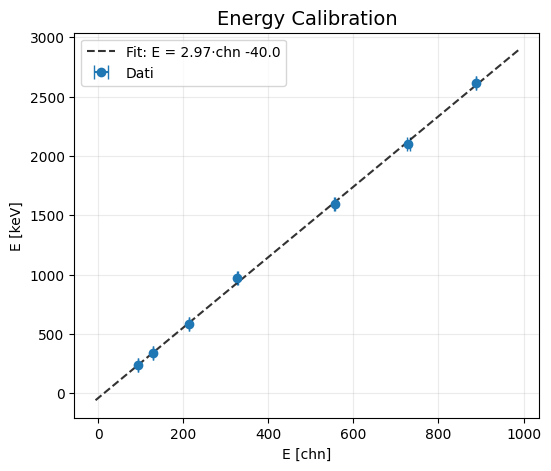

In [55]:
plt.figure(figsize = (6,5))
plt.errorbar( popts[:,1],E_kev_lc, xerr=pcovs[:,1], fmt='o', capsize=5, label='Dati')

p0 = [5, -1 ]
popt, pcov = curve_fit(k_calibration, popts[:,1], E_kev_lc, p0=p0 )
# Incertezze
perr = np.sqrt(np.diag(pcov))
a_lc = popt[0]
b_lc = popt[1]

# Plot
x_fit = np.linspace(min(popts[:,1])-100, max(popts[:,1])+100, 500)
y_fit = k_calibration(x_fit, *popt)
plt.plot(x_fit, y_fit, label=f"Fit: E = {popt[0]:.2f}·chn {popt[1]:.1f}",  color='black', ls = '--', alpha = 0.8)

plt.legend()
plt.xlabel('E [chn]', size = 10)
plt.ylabel('E [keV]', size = 10)
plt.title('Energy Calibration', size = 14)
plt.grid(alpha =0.25)


In [56]:
channels_cl= np.arange( len(spectrum_clos_lense))         # x originale
energies_cl = a_lc* channels_cl  + b_lc

In [57]:
len(channels_cl*a_lc + b_lc)
print(len(energies_cl))

1022


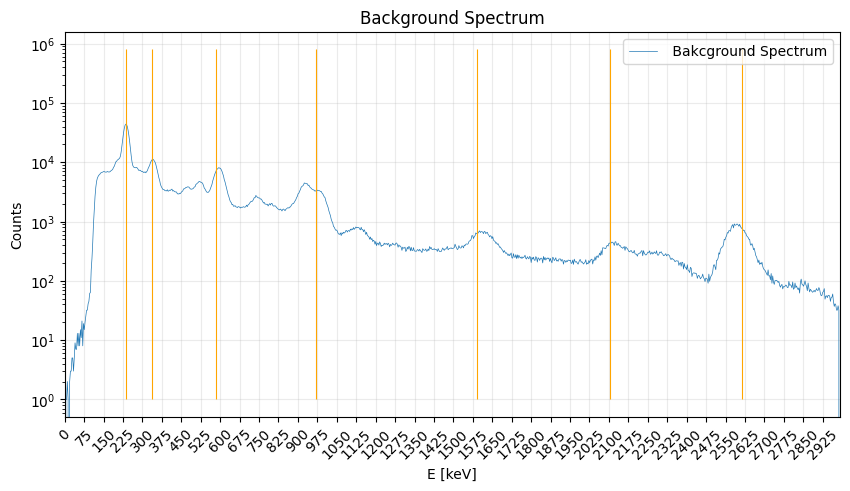

In [58]:
plt.figure(figsize=(10,5))
plt.plot(energies_cl, spectrum_clos_lense, lw = 0.5, label=' Bakcground Spectrum')
#plt.hist(energies_cl, bins = np.linspace(min(energies_cl), max(energies_cl), len(energies_cl)), weights = spectrum_clos_lense,fc = 'orange', lw = 0.5, label=' Bakcground Spectrum')
plt.xlabel('E [keV]')
plt.ylabel('Counts')
plt.title('Background Spectrum')
plt.xlim(0, max(energies_cl))
for e in E_kev_lc:
    plt.vlines(e, 1, 800000, lw = 0.8, color = 'orange')


plt.xticks(np.arange(0,3000,75), rotation = 45)
plt.yscale('log')
plt.legend()
plt.grid(alpha = 0.25)
plt.show()

In [59]:
E_kev_lc

[238, 338, 583, 968, 1592, 2103, 2614]

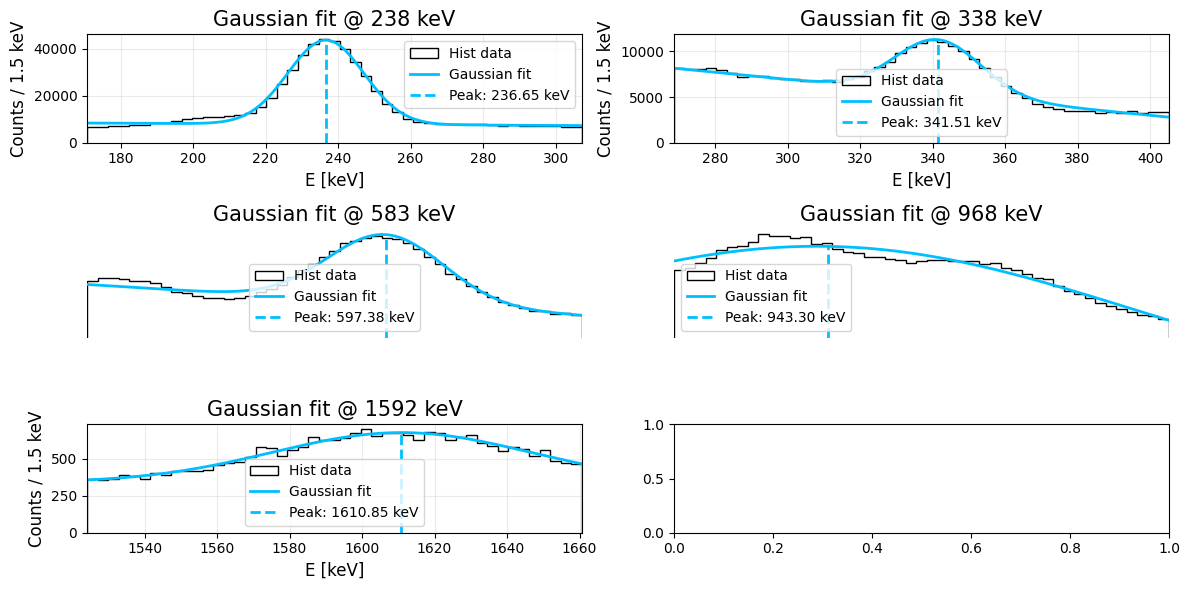

In [60]:
popt_kev = []
popt_kev_err = []
dx_arr = [ 25, 20,25,80,75]
fig, axes = plt.subplots(3, 2, figsize=(12, 6))  # 3 righe, 2 colonne
for  i,(e,dx) in enumerate(zip(E_kev_lc, dx_arr)):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    dx = 70
    popt, err = fit_func_1( spectrum_clos_lense, e, dx = dx, kev = True, energies = energies_cl, ax = ax)
    popt_kev.append(popt)
    popt_kev_err.append(err*1.5)
popt_kev = np.vstack(popt_kev)
popt_kev_err = np.vstack(popt_kev_err)

for j in range(len(E_kev), 4):
    row = j // 2
    col = j % 2
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [61]:
popt_kev

array([[ 3.57563157e+04,  2.36646804e+02,  1.05084098e+01,
         5.39751622e+03,  6.14374797e+03, -7.86464628e+00,
         9.70562739e+03],
       [ 5.99233941e+03,  3.41509169e+02,  1.18435537e+01,
         6.76448835e+02,  2.34407549e+02, -3.92832792e+01,
         1.87160646e+04],
       [ 5.45395363e+03,  5.97379290e+02,  1.60214478e+01,
         6.87458875e+00,  8.26021074e+01, -1.80617396e+01,
         1.35389452e+04],
       [ 6.52292873e+03,  9.43296888e+02,  8.57970316e+01,
         2.56290251e+02,  2.59739077e+02, -2.72174983e+00,
         1.14189948e-06],
       [ 3.36397728e+02,  1.61084681e+03,  3.55032121e+01,
         1.34816012e+03,  1.49571571e+04, -1.22532766e-10,
         3.38737561e+02]])

In [62]:
for i in range(0, len(popt_kev[:,1])):
    mu_kev = popt_kev[:,1]
    mu_kev_err = popt_kev_err[:,1]
    mu_theo = E_kev_lc[i]
    mu_exo = mu_kev[i]
    err = mu_kev_err[i]
    _ = t_test_theoretical(mu_exo,err,mu_theo)

t = -3.35
✅ p > 0.05 
p-value = 0.1845
t = 7.12
✅ p > 0.05 
p-value = 0.0889
t = 17.45
❌ p < 0.05 
p-value = 0.0365
t = -0.37
✅ p > 0.05 
p-value = 0.7768
t = 4.58
✅ p > 0.05 
p-value = 0.1369


incertezza grandi solo 3 punti del fit
paramters: [2.18107926 0.0313029 ]
Errori: [0.09457474 0.01700664]


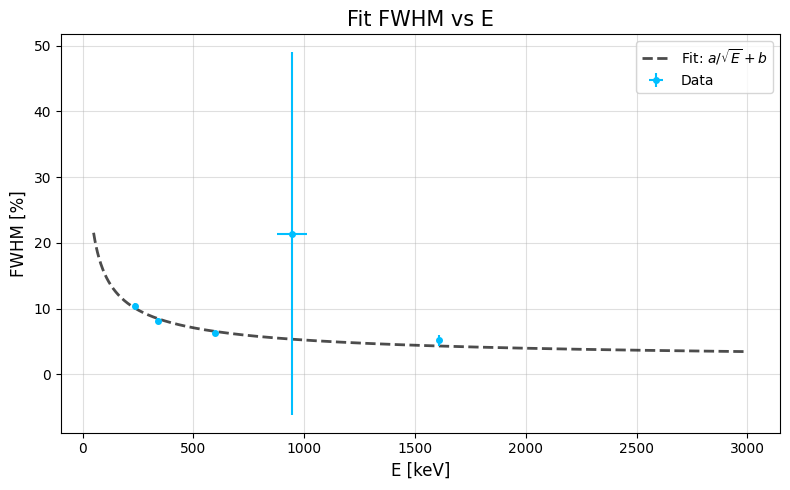

In [63]:
# Calcolo FWHM e incertezza
sigma= popt_kev[:,2]
sigma_err_kev=popt_kev_err[:,2]
mu_kev=popt_kev[:,1]
mu_kev_err =popt_kev_err[:,1]
FWHM, FWHM_err = fwhm_percentuale(sigma, sigma_err_kev, mu_kev, mu_kev_err)
# Fit con curve_fit, usando incertezza su y
boundary = ([0,0],[10000,10000])
p0=[3,0]
popt_res_close_lense, pcov = curve_fit(fhwm_func, mu_kev, FWHM, sigma = FWHM_err,  p0=p0, bounds=boundary)
print('incertezza grandi solo 3 punti del fit')
print("paramters:", popt_res_close)
print("Errori:", np.sqrt(np.diag(pcov)))

# Preparazione plot
E_fit = np.linspace(50, (3000), 1000)

plt.figure(figsize=(8, 5))
plt.ylabel('FWHM [%]')
# Fit teorico
plt.plot(E_fit, fhwm_func(E_fit, *popt_res_close_lense)*100, label=r'Fit: $a/\sqrt{E} + b$', color='black', ls = '--', alpha = 0.7, lw=2)
# Dati con errore su x e y, e stile pallini
# Dati con errore su x e y, e stile pallini
plt.errorbar(mu_kev, FWHM*100,
             xerr=mu_kev_err,
             yerr=FWHM_err*100,
             fmt='o',     
             color = 'deepskyblue',           
             markersize=4,               # dimensione punto
             label='Data')

a_res_cs = popt_res_close[0]
b_res_cs  = popt_res_close[1]

# Etichette
plt.xlabel('E [keV]', size = 12)
plt.ylabel('FWHM [%]', size = 12)
plt.title('Fit FWHM vs E', size = 15)
plt.grid(alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# Lense Unshield OPEN


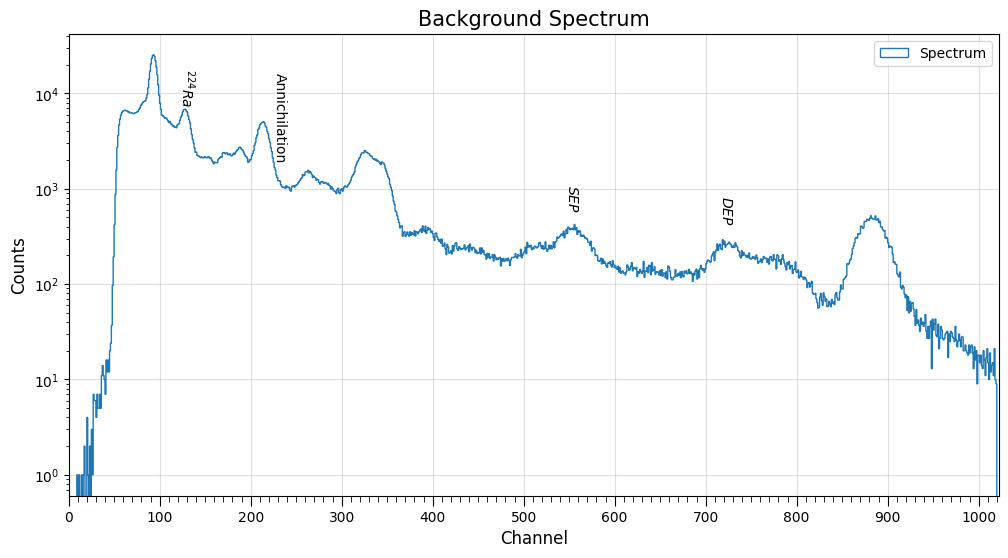

In [64]:
file_path = "lense-open.csv"
data = pd.read_csv(file_path, header=None)

# Ensure data is 1D (each count per channel/bin)
spectrum_ol = data[0].values
#spectrum_ol = spectrum/(1- (t_lense_open_live/t_lense_open_real))
plt.figure(figsize=(12, 6))
dx = 100
dy = 10
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero

chn = np.arange(len(spectrum_ol))  # canali da 0 a N-1
bins = np.linspace(min(chn), max(chn), int(len(chn))+1)
hist, bin_edge, _ = plt.hist(chn, bins = bins, weights= spectrum_ol, histtype='step', ec='k',label='Spectrum')
db = 0.5*(bin_edge[1]-bin_edge[0])
plt.text(120 , 7.7e3, r'$^{224}Ra$', rotation=270,  size = 10)
plt.text(225 , 2e3, r'Annichilation', rotation=270,  size = 10)
plt.text(545 , 0.6e3, r'$SEP$', rotation=270,  size = 10)
plt.text(715 , 0.45e3, r'$DEP$', rotation=270,  size = 10)
plt.xlabel('Channel', size = 12)
plt.ylabel('Counts', size = 12)
plt.title('Background Spectrum', size = 15)
plt.yscale('log')
plt.xlim(0, len(spectrum))
plt.legend()
plt.grid(alpha =0.4)
plt.show()

In [65]:
energies_bkg = a_bkg * channels_bkg  + b_bkg
mask = (energies_bkg > min(energies_bkg)) & (energies_bkg < 3000)

cps_total = np.sum(spectrum_ol)/(t_lense_closed_real)

print(f'count rate totale {cps_total:.0f} cps')

count rate totale 1248 cps


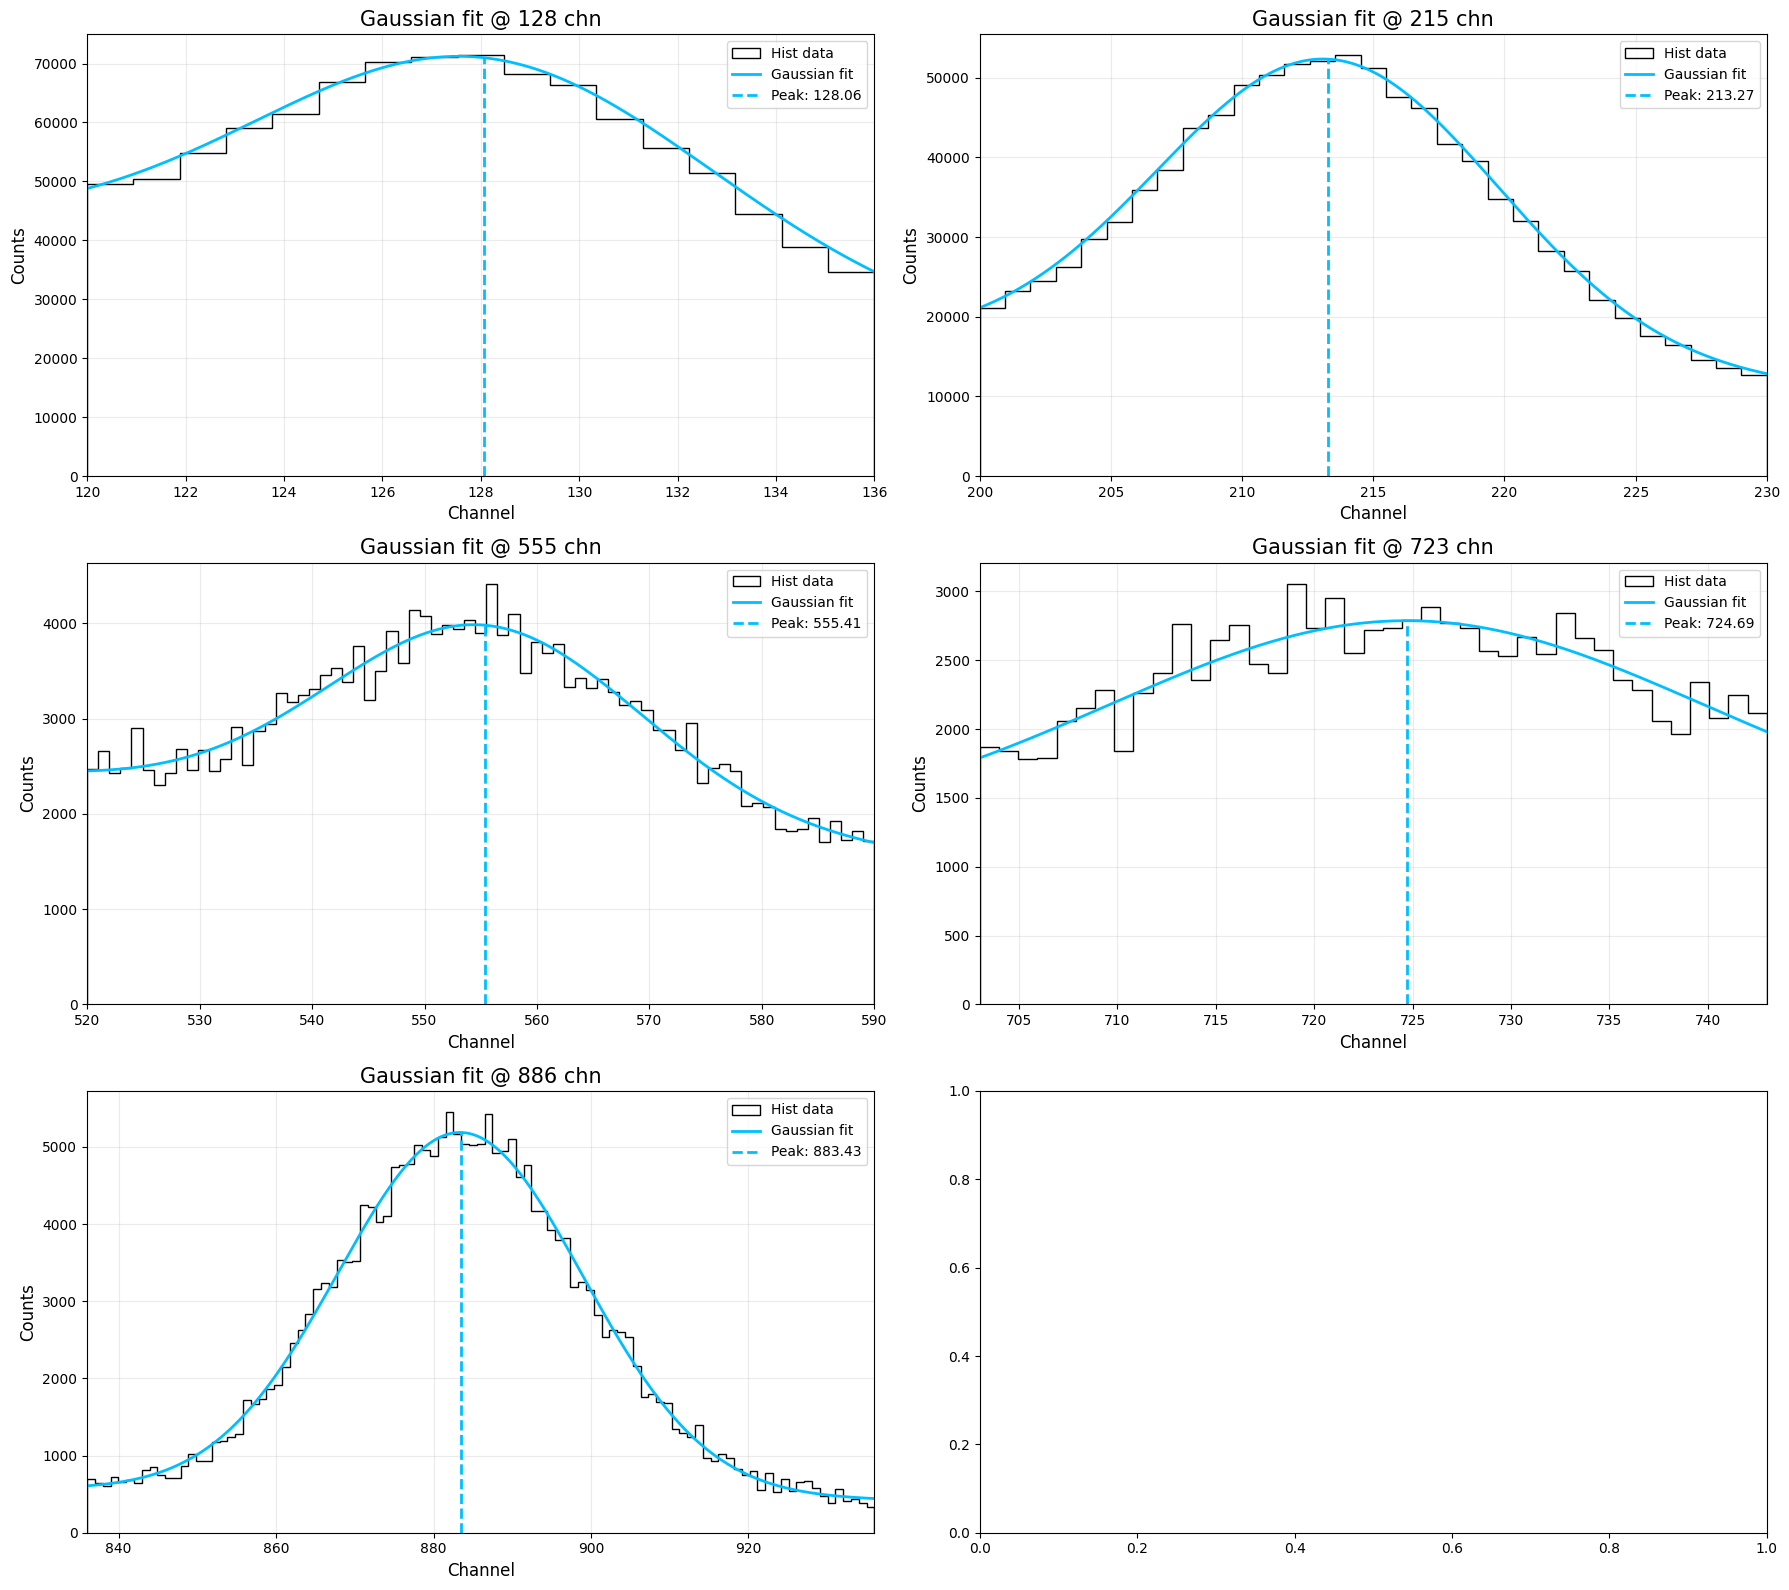

In [124]:
#chn = [ 93, 128,215,555,  886]
chn = [ 128, 213,553,725,  884]
chn = [ 128,215,555, 723, 886]
dx_arr = [8,15,35,20, 50]
popts = []
pcovs = []

fig, axes = plt.subplots(3, 2, figsize=(18, 16)) 
for i, (e,dx) in enumerate(zip(chn,dx_arr)):
    #print(e)
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    popt, pcov = fit_func_1(spectrum_ol, e, dx = dx,  ax = ax)
    #print(popt)
    popts.append(popt)
    pcovs.append(pcov)
popts = np.vstack(popts) 
pcovs = np.vstack(pcovs)

for j in range(len(chn),5 ):
    row = j // 2
    col = j % 2
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

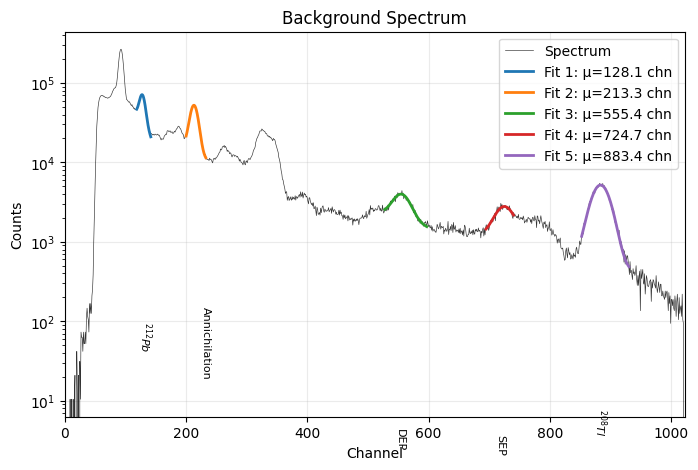

In [126]:
plt.figure(figsize=(8, 5))
plt.plot(spectrum_ol, color = 'black', lw = 0.46, alpha = 0.8, label='Spectrum')
for i, popt in enumerate(popts):
    A, mu, sigma, a,b,c,d = popt
    if i == 3:
        x_fit = np.linspace(mu - 2*sigma, mu + sigma, 300)
    else:
        x_fit = np.linspace(mu - 2*sigma, mu + 3*sigma, 300)
    y_fit = gaussian_offset(x_fit, *popt)
    plt.plot(x_fit, y_fit, lw = 2,  label=f'Fit {i+1}: μ={mu:.1f} chn')

plt.text(120 , 4.5e1, r'$^{212}Pb$', rotation=270,  size = 8)
plt.text(225 , 2e1, r'Annichilation', rotation=270,  size = 8)
plt.text(545 , 0.25e1, r'DEP', rotation=270,  size = 8)
plt.text(710 , 0.22e1, r'SEP', rotation=270,  size = 8)
plt.text(870 , 0.4e1, r'$^{208}Tl$', rotation=270,  size = 8)
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.title('Background Spectrum')
plt.xlim(0, len(spectrum_ol))
plt.yscale('log')

plt.legend()
plt.grid(alpha = 0.25)
plt.show()

In [127]:
E_kev_lc = [  238.632, 511, 1592 ,2103, 2614] #kev

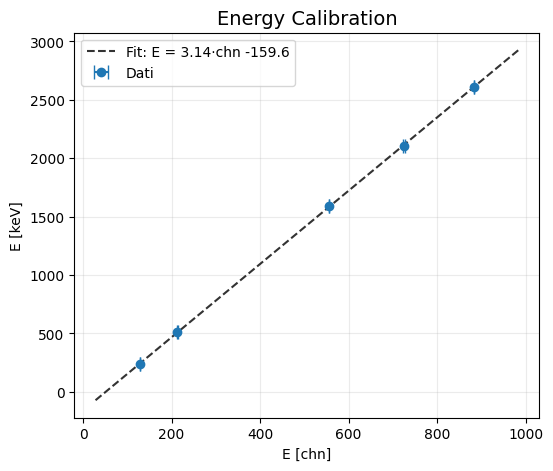

In [128]:
plt.figure(figsize = (6,5))
plt.errorbar( popts[:,1],E_kev_lc, xerr=pcovs[:,1], fmt='o', capsize=5, label='Dati')

p0 = [5, -1 ]
popt, pcov = curve_fit(k_calibration, popts[:,1], E_kev_lc, p0=p0 )
# Incertezze
perr = np.sqrt(np.diag(pcov))
a_oc = popt[0]
b_oc = popt[1]

# Plot
x_fit = np.linspace(min(popts[:,1])-100, max(popts[:,1])+100, 500)
y_fit = k_calibration(x_fit, *popt)
plt.plot(x_fit, y_fit, label=f"Fit: E = {popt[0]:.2f}·chn {popt[1]:.1f}",  color='black', ls = '--', alpha = 0.8)

plt.legend()
plt.xlabel('E [chn]', size = 10)
plt.ylabel('E [keV]', size = 10)
plt.title('Energy Calibration', size = 14)
plt.grid(alpha =0.25)


In [129]:
channels_ol= np.arange( len(spectrum_ol))         # x originale
energies_ol = a_oc* channels_ol  + b_oc

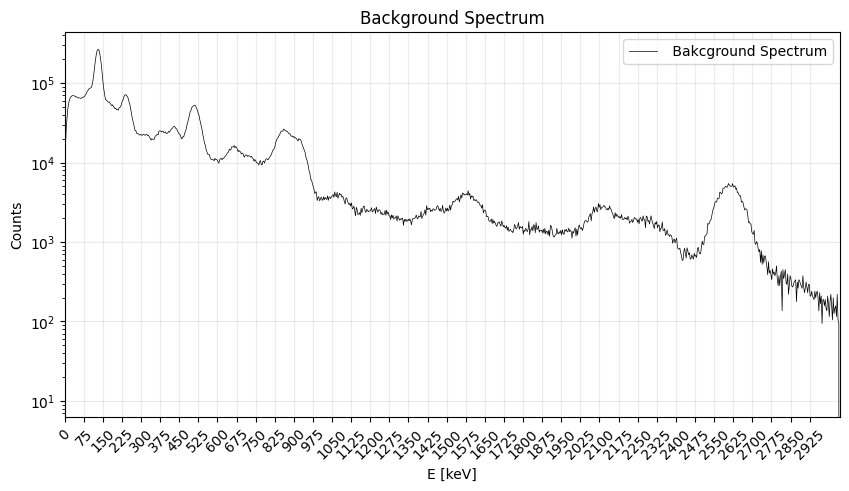

In [130]:
plt.figure(figsize=(10,5))
plt.plot(energies_ol, spectrum_ol, lw = 0.5,color = 'black', label=' Bakcground Spectrum')
#plt.hist(energies_cl, bins = np.linspace(min(energies_cl), max(energies_cl), len(energies_cl)), weights = spectrum_clos_lense,fc = 'orange', lw = 0.5, label=' Bakcground Spectrum')
plt.xlabel('E [keV]')
plt.ylabel('Counts')
plt.title('Background Spectrum')
plt.xlim(0, max(energies_ol))
plt.xticks(np.arange(0,3000,75), rotation = 45)
#plt.ylim(1, 800)
plt.yscale('log')
plt.legend()
plt.grid(alpha = 0.25)
plt.show()

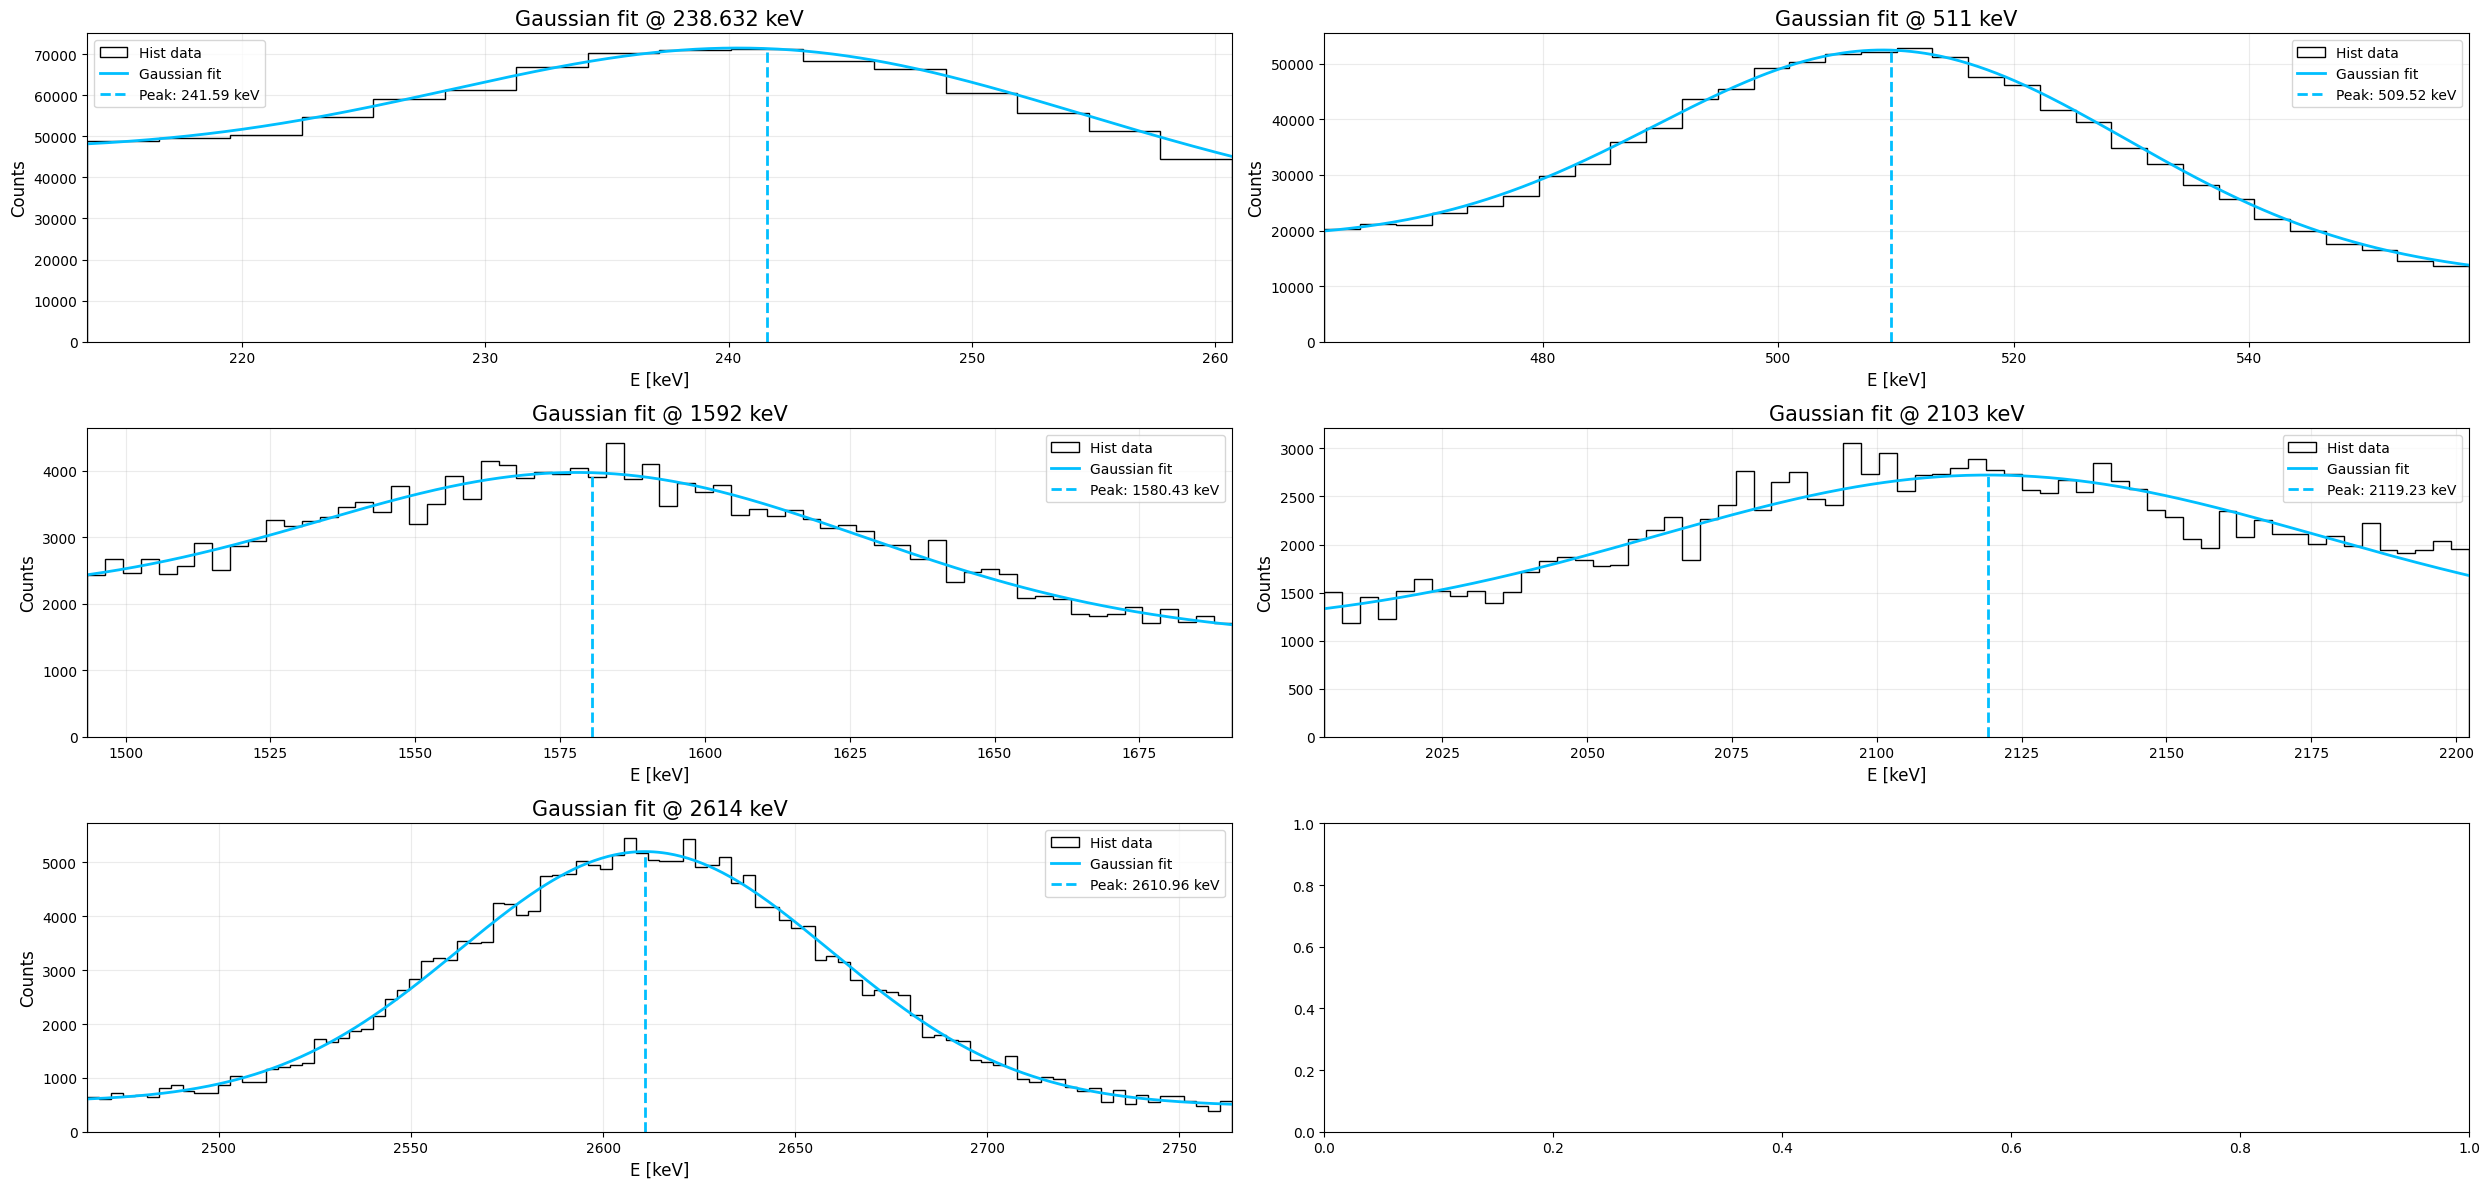

In [133]:
popt_kev = []
popt_kev_err = []
dx_arr = [ 25, 50,100,100, 150]
fig, axes = plt.subplots(3, 2, figsize=(25, 12))  # 3 righe, 2 colonne
for  i,(e,dx) in enumerate(zip(E_kev_lc, dx_arr)):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    popt, err = fit_func_1( spectrum_ol, e, dx = dx, kev = True, energies = energies_ol, ax = ax)
    popt_kev.append(popt)
    popt_kev_err.append(err)
popt_kev = np.vstack(popt_kev)
popt_kev_err = np.vstack(popt_kev_err)


plt.tight_layout()
plt.show()

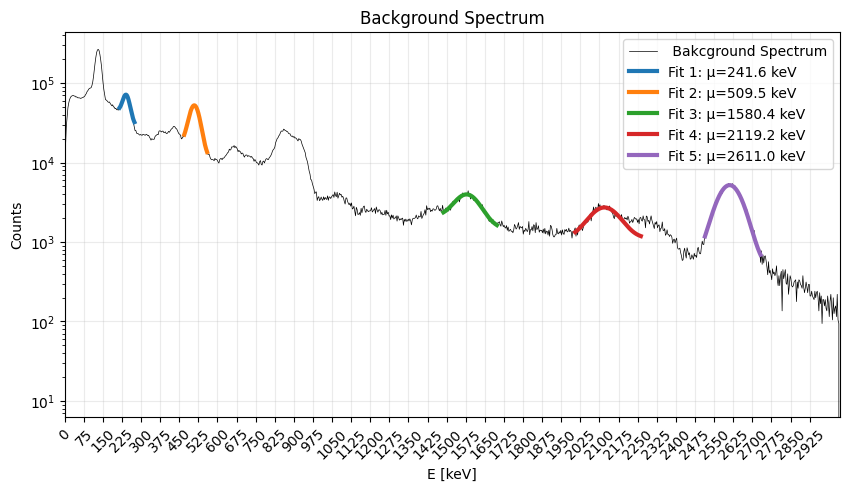

In [135]:
plt.figure(figsize=(10,5))
plt.plot(energies_ol, spectrum_ol, lw = 0.5,color = 'black', label=' Bakcground Spectrum')
#plt.hist(energies_cl, bins = np.linspace(min(energies_cl), max(energies_cl), len(energies_cl)), weights = spectrum_clos_lense,fc = 'orange', lw = 0.5, label=' Bakcground Spectrum')
plt.xlabel('E [keV]')
plt.ylabel('Counts')
plt.title('Background Spectrum')
plt.xlim(0, max(energies_ol))
for i, popt in enumerate(popt_kev):
    A, mu, sigma, a,b,c,d = popt
    x_fit = np.linspace(mu - 2*sigma, mu + 2.5*sigma, 300)
    y_fit = gaussian_offset(x_fit, *popt)
    
    plt.plot(x_fit, y_fit, lw = 3, label=f'Fit {i+1}: μ={mu:.1f} keV')
plt.xticks(np.arange(0,3000,75), rotation = 45)
#plt.ylim(1, 800)
plt.yscale('log')
plt.legend()
plt.grid(alpha = 0.25)
plt.show()

In [136]:
for i in range(0, len(popt_kev[:,1])):
    mu_kev = popt_kev[:,1]
    mu_kev_err = popt_kev_err[:,1]
    mu_theo = E_kev_lc[i]
    mu_exo = mu_kev[i]
    err = mu_kev_err[i]
    _ = t_test_theoretical(mu_exo,err,mu_theo)

t = 4.96
✅ p > 0.05 
p-value = 0.1267
t = -7.57
✅ p > 0.05 
p-value = 0.0836
t = -5.41
✅ p > 0.05 
p-value = 0.1164
t = 2.74
✅ p > 0.05 
p-value = 0.2230
t = -5.82
✅ p > 0.05 
p-value = 0.1083


incertezza grandi solo 3 punti del fit
paramters: [1.64587887 0.04882314]
Errori: [0.07132576 0.00437394]


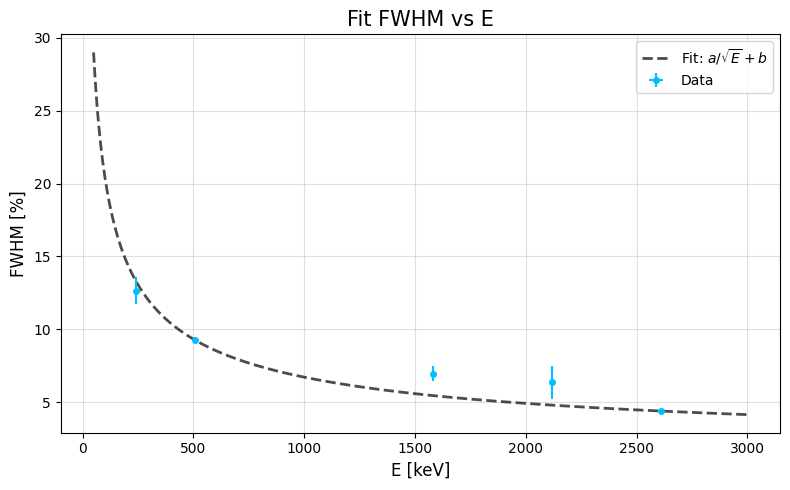

In [137]:
# Calcolo FWHM e incertezza
sigma= popt_kev[:,2]
sigma_err_kev=popt_kev_err[:,2]
mu_kev=popt_kev[:,1]
mu_kev_err =popt_kev_err[:,1]
FWHM, FWHM_err = fwhm_percentuale(sigma, sigma_err_kev, mu_kev, mu_kev_err)
# Fit con curve_fit, usando incertezza su y
boundary = ([0,0],[10000,10000])
p0=[3,0]
popt_res_open, pcov = curve_fit(fhwm_func, mu_kev, FWHM, sigma = FWHM_err,  p0=p0, bounds=boundary)
print('incertezza grandi solo 3 punti del fit')
print("paramters:", popt_res_close)
print("Errori:", np.sqrt(np.diag(pcov)))

# Preparazione plot
E_fit = np.linspace(50, (3000), 1000)

plt.figure(figsize=(8, 5))
plt.ylabel('FWHM [%]')
# Fit teorico
plt.plot(E_fit, fhwm_func(E_fit, *popt_res_open)*100, label=r'Fit: $a/\sqrt{E} + b$', color='black', ls = '--', alpha = 0.7, lw=2)
# Dati con errore su x e y, e stile pallini
plt.errorbar(mu_kev, FWHM*100,
             xerr=mu_kev_err,
             yerr=FWHM_err*100,
             fmt='o',     
             color = 'deepskyblue',               
             markersize=4,               # dimensione punto
             label='Data')

a_res_os = popt_res_close[0]
b_res_os  = popt_res_close[1]

# Etichette
plt.xlabel('E [keV]', size = 12)
plt.ylabel('FWHM [%]', size = 12)
plt.title('Fit FWHM vs E', size = 15)
plt.grid(alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# Risoluzioni energetiche sorgente


Risoluzioni energetiche calcolate priam di aver sottratto il abckground

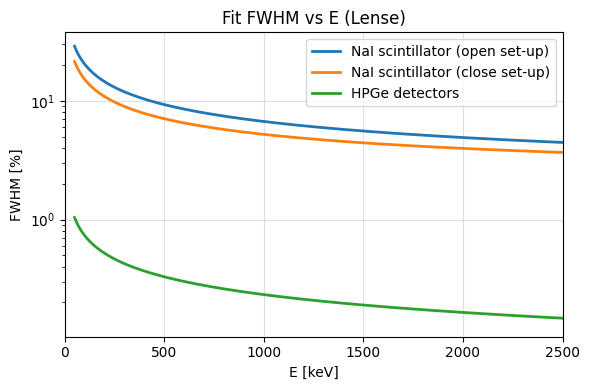

In [138]:
plt.figure(figsize=(6, 4))
plt.ylabel('FWHM [%]')
# Fit teorico
plt.plot(E_fit, fhwm_func(E_fit, *popt_res_open)*100, label=r'NaI scintillator (open set-up)',lw=2)
plt.plot(E_fit, fhwm_func(E_fit, *popt_res_close_lense)*100, label=r'NaI scintillator (close set-up)',lw=2)
plt.plot(E_fit, fhwm_func(E_fit,7.36278329e-02, 6.09959602e-16)*100, label=r'HPGe detectors',  lw=2)

# Etichette
plt.xlabel('E [keV]')
plt.ylabel('FWHM [%]')
plt.title('Fit FWHM vs E (Lense)')
plt.grid(alpha=0.4)
plt.legend()
plt.xlim(0, 2500)
plt.yscale('log')
plt.tight_layout()
plt.show()

# Spectrum Overlap

## Background

In [83]:
# Load the spectrum data
file_path = "BKG_only.csv"
data = pd.read_csv(file_path, header=None)

# Ensure data is 1D (each count per channel/bin)
spectrum_HPGe= data[0].values

# correggo col dead time il background---> lo faccio subito in modod talr da avere già lo sesso spettro corretto ed avere la stessa risoluszione enrgetica. il dead time peggior la risoluzione
t_live_b = 76747
t_real_b = 76752
# correggo subito per il tempo morto
D_b = 1-(t_live_b/t_real_b)

spectrum_HPGe = spectrum_HPGe/D_b

spectrum_HPGe[spectrum_HPGe <= 0 ] = 10000 # rimuovi negativi

chn = np.linspace(0, len(spectrum_HPGe), len(spectrum_HPGe))
ene = 0.4373820282 * chn + 4.68475015568

In [69]:
t_bk_closed_live

11001

In [70]:
t_bk_open_live

11772

In [71]:
file_path = "bkg-unshileded.csv.csv"
data = pd.read_csv(file_path, header=None)
# Ensure data is 1D (each count per channel/bin)
spectrum = data[0].values
spectrum_unshield = spectrum  * (t_bk_closed_live / t_bk_open_live)

In [72]:
file_path = "bkg-shield.csv"
data = pd.read_csv(file_path, header=None)
# Ensure data is 1D (each count per channel/bin)
spectrum = data[0].values
# normalizzo per il tempo piu corto
spectrum_shield = spectrum


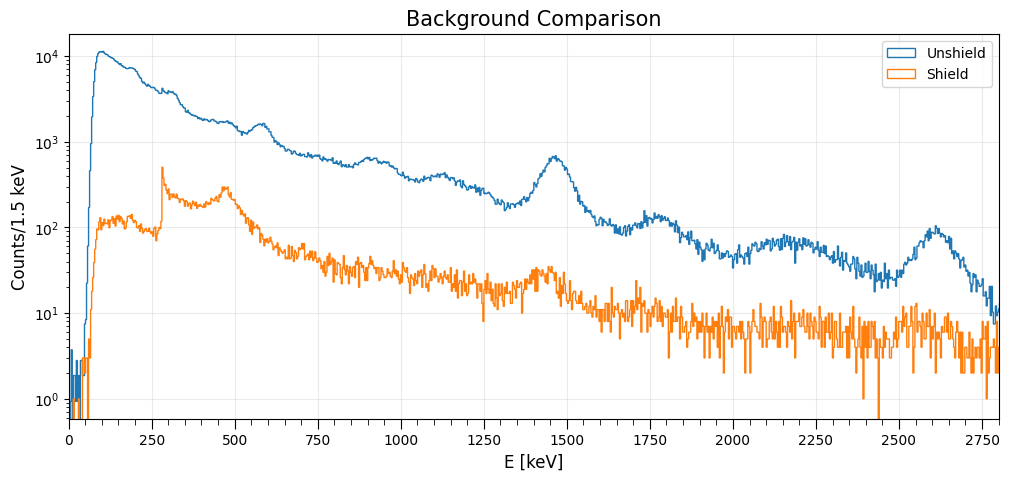

In [79]:
 
plt.figure(figsize=(12, 5))

dx = 250
dy = 50
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero


#plt.hist(ene, bins = len(spectrum_HPGe), weights= spectrum_HPGe, histtype='step', ec='k',label='HPGe')
chn = np.linspace(0, len(spectrum_unshield), len(spectrum_unshield))
plt.hist(a_bkg * chn  + b_bkg, bins = len(spectrum_unshield), weights= spectrum_unshield, histtype='step', ec='k',label='Unshield')
chn = np.linspace(0, len(spectrum_shield), len(spectrum_shield))

c, b_g, _ = plt.hist(a_bkg * chn  + b_bkg, bins = len(spectrum_shield), weights= spectrum_shield, histtype='step', ec='k',label='Shield')
db = 0.5*(b_g[1]-b_g[0])
plt.xlabel('E [keV]', size = 12)
plt.ylabel(f'Counts/{db:.1f} keV', size = 12)
plt.title('Background Comparison', size = 15)
plt.yscale('log')
plt.xlim(0, 2800)
plt.legend()
plt.grid(alpha =0.25)
plt.show()

## Signal

In [88]:
# Load the spectrum data
file_path = "HPGe/238U.csv"
data = pd.read_csv(file_path, header=None)

# Ensure data is 1D (each count per channel/bin)
spectrum_U = data[0].values

# correggo col dead time l'uranio
t_live_u = 601
t_real_u = 625
# correggo subito per il tempo morto
D_u = 1-(t_live_u/t_real_u)

spectrum_HPGe = spectrum_U/D_u


chn = np.linspace(min(spectrum_U), max(spectrum_U), len(spectrum_U))
ene = 0.4373385256721 * chn + 4.55466296

In [69]:
file_path = "lense_closed.csv"
data = pd.read_csv(file_path, header=None)

# Ensure data is 1D (each count per channel/bin)
spectrum = data[0].values
spectrum_clos_lense = spectrum/(1- (t_lense_closed_live/t_lense_closed_real))
spectrum_shield = spectrum_clos_lense * t_lense_open_real / t_lense_closed_real 

In [70]:
file_path = "lense-open.csv"
data = pd.read_csv(file_path, header=None)

# Ensure data is 1D (each count per channel/bin)
spectrum = data[0].values
spectrum_ol = spectrum/(1- (t_lense_open_live/t_lense_open_real))
spectrum_unshield = spectrum_ol *t_lense_open_real /  t_lense_open_real 

In [71]:
plt.figure(figsize=(30, 5))
# Ensure data is 1D (each count per channel/bin)
spectrum = data[0].values
spectrum = spectrum*(1-(t_bk_open_live/t_bk_closed_real))
plt.figure(figsize=(8, 5))

#plt.hist(ene, bins = len(spectrum_HPGe), weights= spectrum_HPGe, histtype='step', ec='k',label='HPGe')
chn = np.linspace(0, len(spectrum_unshield), len(spectrum_unshield))
plt.hist(a_oc * chn  + b_oc, bins = len(spectrum_unshield), weights= spectrum_unshield, histtype='step', ec='k',label='Unshield')
chn = np.linspace(0, len(spectrum_shield), len(spectrum_shield))
plt.hist(a_lc * chn  + b_lc, bins = len(spectrum_shield), weights= spectrum_shield, histtype='step', ec='k',label='Shield')

plt.xlabel('Channel', size = 12)
plt.ylabel('Counts', size = 12)
plt.title('Signal Comparison', size = 15)


plt.yscale('log')
plt.xlim(0, 2800)
plt.legend()
plt.grid(alpha =0.4)
plt.show()

NameError: name 'a_oc' is not defined

<Figure size 3000x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [83]:
(1- 994/1099)*100

9.554140127388532

In [84]:
(1- 862/971)*100

11.225540679711631

In [87]:
(1-11772/11782)*100

0.08487523340688918

In [88]:
11001/3600


3.055833333333333

In [89]:
971/60

16.183333333333334